In [4]:
import sys
import os
sys.path.append(os.path.abspath('..'))
%matplotlib inline
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt
import seaborn as snb

from scipy.stats import poisson
from scipy.stats import gamma

from exercise9 import compute_effective_sample_size
from exercise9 import compute_Rhat
from exercise9 import plot_summary
from exercise9 import metropolis

# we want to use 64 bit floating precision
import jax
jax.config.update("jax_enable_x64", True)

# style stuff
snb.set_style('darkgrid')
snb.set_theme(font_scale=1.1)

# 02477 Bayesian Machine Learning - Exercise 9

### Overview

Markov Chain Monte Carlo (MCMC) techniques like Metropolis-Hastings and Gibbs sampling are very powerful methods in machine learning and statistics as they provide the computational tools for generating samples from complex distributions, e.g. posterior distributions of complex non-conjugate Bayesian models, but they are by no means limiting the Bayesian models.

The purpose of this exercise is to become familiar with Gibbs sampling as well as the Markov Chain Monte Carlo convergence diagnostics. First, we will study how to detect convergence in practice and how to compute the effective number of samples by taking the autocorrelation of the MCMC into account. Then, we will study Gibbs sampling using a simple Bayesian model for change point detection.


**Content**

- Part 1: The $\hat{R}$-statistic and the effective sample size
- Part 2: A simple model for change point detection in time series using Gibbs sampling
- Part 3: Implementing the Gibbs sampler
- Part 4: Visualizing the posterior distributions for the change point detection model



**Note**: The exercise contains several **discussion questions**, which are questions, where are supposed to actively experiment with the code and/or reason with the equations to arrive at the relevant conclusions. This also means that we won't provide a specific solution for this task. However, you are more than welcome to check your understanding and your conclusions with the TAs. Instead of proving the full description for every discussion question, we simply tag it with: [**Discussion question**] after the question.
___

## Part 1:  The $\hat{R}$-statistic and the effective sample size

The purpose of the first part is to become familar with the MCMC convergence diagnostics denoted $\hat{R}$ as well as the effective sample size $S_\text{eff}$.  MCMC theory states that a well-designed MCMC algorithm converges asymptotically to the true target distribution, meaning that the Markov chain eventually will converge to the target distribution. The downside is that there is no strict theory for predicting when a chain will reach its stationary distribution, but there do exist heuristics that work very well in practice.


**Assessing convergence**

Intuitively, we can test convergence by running **multiple chains** in parallel starting from **different initial conditions**. After a given number of iterations, we can compare the chains. If the chains have reached stationarity, then they should all have the same stationary distribution independent of the initial condition. Therefore, if our chains do not have the same distributions, we can conclude the chains have not reached stationarity yet. In this case, we say that the chains have not **mixed**.

In practice, the so-called $\hat{R}$-statistic, also called the **potential scale reduction factor**, works well for assessing convergence:

$$\begin{align*}
\hat{R}^2 = \frac{S-1}{S} + \frac{1}{S}\frac{B}{W} \tag{1},
\end{align*}$$

where $S$ is the number of samples/iterations, $B$ is the **between-chain variance** and $W$ is the **within-chain variance**. If the between-chain variance is equal to the within-chain variance, then $\hat{R} = 1$, otherwise $\hat{R} > 1$. For most applications, the threshold $\hat{R} < 1.1$ works well for assesing convergence, but for more critical applications the threshold $\hat{R} < 1.01$ is recommended.

For more details, see Section 12.6.2.2. in Murphy2 or see p. 284 in Bayesian Data Analysis (http://www.stat.columbia.edu/~gelman/book/BDA3.pdf).

____

**Effective sample size**

Another very useful statistic in MCMC is the so-called **effective sample size (ESS)** defined by

$$\begin{align}
S_{\text{eff}}  = \frac{S}{\sum_{t=-\infty}^{\infty} \rho_t} = \frac{S}{1 + 2\sum_{t=1}^\infty \rho_t}\tag{2},
\end{align}$$


where $\rho_t$ is the autocorrelation of the chains at time lag $t$. Informally, a set of $S$ MCMC samples contains less information than $S$ independent samples from the same distribution due to the correlation between MCMC samples. The effective sample size helps us correct for this when computing the MCSE.

The provided functions `compute_Rhat` and `compute_effective_sample_size` compute $\hat{R}$ and $S_{\text{eff}}$, respectively. 

These diagnostics are evalauted after removing the **warmup** samples. And after we computed the diagnostics, we **merge** the samples from the individual chains into one long chain before using the samples for inference purposes.
____

**A bi-modal toy distribution**

To build intuition, we will first investigate these two statistics for a simple toy distribution, where we can easily compute the mean and variance reference:

$$\begin{align*}
p(x) = \frac12 \mathcal{N}(x| -3, 4) + \frac12 \mathcal{N}(x|1,2) \tag{3}
\end{align*}$$

Computing the first two moments yields (if you don't know how to do this, ask the teachers):


$$\begin{align*}
\mathbb{E}\left[x\right] &=  \frac12 \cdot (-3) + \frac12\cdot 1 = -1\\
\mathbb{E}\left[x^2\right] &=  \frac12 \cdot ((-3)^2 + 4) + \frac12\cdot (1^2 + 2) = 8,
\end{align*}$$

and hence, the variance of $p(x)$ is

$$\begin{align*}
\mathbb{V}\left[x\right] = \mathbb{E}\left[x^2\right] - \mathbb{E}\left[x\right]^2 = 8 - (-1)^2 = 7.
\end{align*}$$

_____

Let's plot the density

Text(0.5, 0, '$x$')

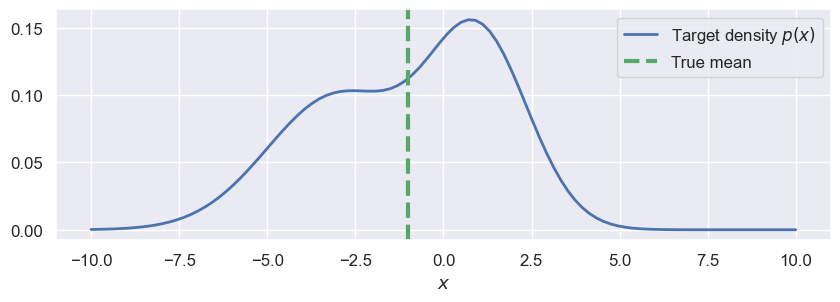

In [5]:
# npdf(x, m, v) computes the probability density function (pdf) of a Gaussian distribution
# with mean m and variance v at point(s) x.
# ----------------------------------------------------------------------------
# Input:
#   x : jnp.array of shape (N, 1) or (N,) – the points at which we evaluate the pdf
#   m : float – mean of the Gaussian
#   v : float – variance of the Gaussian (must be > 0)
# Output:
#   jnp.array of shape (N,) – pdf values for each point x
# ----------------------------------------------------------------------------
# Equation for Gaussian pdf:
#   N(x | m, v) = (1 / sqrt(2πv)) * exp( - (x - m)^2 / (2v) )
npdf = lambda x, m, v: jnp.exp(-(x - m)**2 / (2 * v)) / jnp.sqrt(2 * jnp.pi * v)
########################################################################################################



#######################################################################################################
# log_target(x) computes the log of the weighted sum of two Gaussian pdfs:
#   0.5 * N(x | -3, 4) + 0.5 * N(x | 1, 2)
# ----------------------------------------------------------------------------
# Input:
#   x : jnp.array of shape (N, 1) or (N,) – the points at which we evaluate the log-density
# Output:
#   jnp.array of shape (N,) – log-density values for each point x
# ----------------------------------------------------------------------------
# Equation for the mixture distribution:
#   p(x) = 0.5 * N(x | -3, 4) + 0.5 * N(x | 1, 2)
#   log_target(x) = log( p(x) )
log_target = lambda x: jnp.log(0.5 * npdf(x, -3, 4) + 0.5 * npdf(x, 1, 2))
########################################################################################################

########################################################################################################
# The true mean and variance of this mixture distribution:
#   mean = -1
#   variance = 7
true_mean = -1
true_var = 7

# We create a linspace of 100 points from -10 to 10; shape = (100,)
# Then reshape it to (100, 1) for convenience in plotting
x_space = jnp.linspace(-10, 10, 100)[:, None]

# Create a figure and axis for plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 3))

# Plot the target density values by exponentiating log_target
ax.plot(
    x_space,                          # shape (100,1)
    jnp.exp(log_target(x_space)),     # shape (100,)
    label='Target density $p(x)$',
    linewidth=2
)

# Draw a vertical line at the true mean
ax.axvline(true_mean, color='g', linestyle='--', label='True mean', linewidth=3)

ax.legend()
ax.set_xlabel('$x$')

Next, we will implement a function that runs multiple MCMC chains using the Metropolis-Hastings algorithm from last week. You can either use your own implementation of the MH algorithm or you can use the one provided in `exercise9.metropolis`.

**Task 1.1**: Complete the implementation of the function `metropolis_multiple_chains` below such that it runs the Metropolis-Hastings sampler `num_chains` times. The function should return two arrays: 1) the samples for each chain and 2) the acceptance rate for each chain.

> The main objective is to run the Metropolis-Hastings (MH) algorithm multiple times, each time with a different starting point and a different random seed. This allows us to get multiple independent samples from the target distribution, which can be helpful for assessing convergence and getting a better overall picture of the distribution.


In [8]:
def metropolis_multiple_chains(log_target, num_params, num_chains, tau, num_iter, theta_init, seeds, warm_up=0):
    """
    Runs multiple Metropolis-Hastings (MH) Markov Chain Monte Carlo (MCMC) chains in parallel.

    **Overview:**
      This function orchestrates running multiple independent MH chains, where each chain
      is initialized with a different starting point and seed. The sampler uses the given
      log_target function to compute the log of the joint probability of the target distribution.
      The candidate proposals for each chain are generated from a Gaussian (Normal) distribution 
      centered at the current state with variance 'tau'. After iterating, a burn-in period (if any)
      is discarded from each chain's samples.

    **Mathematical Background:**
      The MH algorithm proposes a new candidate state $\theta^{*}$ based on the current state $\theta^{(t)}$
      using a proposal density:
          \[
          \theta^{*} \sim \mathcal{N}(\theta^{(t)}, \tau)
          \]
      The acceptance probability $\alpha$ is computed via the ratio of the target densities:
          \[
          \alpha = \min\left(1, \frac{p(\theta^{*})}{p(\theta^{(t)})}\right)
          \]
      In log-space (for numerical stability), this becomes:
          \[
          \alpha = \min\left(1, \exp\left(\log p(\theta^{*}) - \log p(\theta^{(t)})\right)\right)
          \]
      If the candidate $\theta^{*}$ is accepted (with probability $\alpha$), it becomes the next state;
      otherwise, the chain remains at $\theta^{(t)}$.

    **Input Arguments:**
      - log_target:
          A function that computes the log joint probability $ \log p(\theta) $ of the target distribution.
          It should accept a parameter vector (or scalar for one-dimensional problems) and return a scalar.
      - num_params (int):
          Number of parameters (the dimensionality of the space). For a 1D problem, num_params = 1.
      - num_chains (int):
          Total number of independent MCMC chains to run.
      - tau (float):
          Variance (or scaling factor) used in the Gaussian proposal distribution. It controls the size of the 
          proposed moves.
      - num_iter (int):
          The number of iterations to perform for each chain. Note that the chain will actually produce 
          num_iter+1 samples since the initial state is included.
      - theta_init (jnp.array):
          An array containing the initial states for each chain with shape 
          $text{(num_chains, num_params)}$.
      - seeds (jnp.array):
          An array of random seeds, one for each chain, with shape $text{(num_chains,)}$.
      - warm_up (int, optional):
          Number of initial iterations/samples (burn-in period) to discard for each chain. Default is 0.
    
    **Output:**
      - thetas (jnp.array):
          A 3D array of the collected samples from each chain, after discarding warm-up samples.
          Final shape is $(\text{num_chains}, \text{num_iter}+1-\text{warm_up}, \text{num_params})$.
          Here, each chain produces num_iter+1 samples including the initial sample.
      - accept_rates (jnp.array):
          A 1D array of length num_chains, where each element is the acceptance rate (fraction of accepted
          proposals) for that chain.
    
    **Usage Example:**
      ```python
      # Number of chains and iterations
      num_chains = 4
      num_iter = 1000
      proposal_variance = 0.1  # Parameter tau for the Gaussian proposal
      num_params = 1
      warm_up = 0  # No burn-in samples to discard in this example
      seeds = jnp.arange(num_chains)  # One seed per chain

      # Generate initial states from a Normal distribution N(0, 5^2)
      key = random.PRNGKey(1)
      theta_init = 5 * random.normal(key, shape=(num_chains, num_params))  # Shape: (num_chains, num_params)

      # Run the sampler with the target log probability function `log_target`
      chains, accepts = metropolis_multiple_chains(log_target, num_params, num_chains,
                                                   proposal_variance, num_iter,
                                                   theta_init, seeds, warm_up)

      # Compute and print the overall estimated mean and variance from the samples
      estimated_mean = jnp.mean(chains.ravel())
      estimated_variance = jnp.var(chains.ravel())
      print(f'Estimated mean:\t\t{estimated_mean:+3.2f}')
      print(f'Estimated variance:\t{estimated_variance:+3.2f}')
      ```
    """

    # --- Verify Input Dimensions ---
    # Ensure that theta_init has the correct shape: (num_chains, num_params)
    assert theta_init.shape == (num_chains, num_params), (
        "theta_init seems to have the wrong dimensions. Please check your code: expected shape "
        "(num_chains, num_params)."
    )

    ###########################################
    # Step 1. Initialize Containers for Output
    ###########################################
    # Here, two lists are created to store:
    # 1. The chain samples from each independent chain.
    # 2. The corresponding acceptance indicators or rates.
    thetas = []          # Will hold the samples for each chain.
    accept_rates = []    # Will hold the acceptance rate for each chain.

    ###########################################
    # Step 2. Run Each Metropolis Chain
    ###########################################
    # Loop over the number of chains. For each chain, run the individual Metropolis sampler.
    for idx_chain in range(num_chains):
        # Inform the user which chain is currently running
        print(f"Running chain {idx_chain}. ", end='')

        # Run the individual Metropolis sampler (assumed to be pre-defined).
        #
        # The individual sampler 'metropolis' takes as inputs:
        #  - log_target: the log joint probability function.
        #  - num_params: the dimensionality of the state space.
        #  - tau: the variance of the Gaussian proposal distribution.
        #  - num_iter: the number of iterations to run.
        #  - theta_init: the initial state for this specific chain (1D vector of length num_params).
        #  - seed: the random seed for reproducibility in this chain.
        #
        # The function 'metropolis' returns:
        #  - thetas_temp: an array of samples, shape (num_iter + 1, num_params) because it includes the initial state.
        #  - accepts_temp: a list/array of acceptance indicators (1 for accepted move, 0 otherwise) for each iteration.
        thetas_temp, accepts_temp = metropolis(     # shapes (num_iter + 1, num_params) and (num_iter + 1,)
            log_target=log_target,
            num_params=num_params,
            tau=tau,
            num_iter=num_iter,
            theta_init=theta_init[idx_chain],
            seed=seeds[idx_chain]
        )

        # Append the samples and acceptance indicators for the current chain to the respective lists.
        thetas.append(thetas_temp)   # shapes (num_iter + 1, num_params)
        accept_rates.append(jnp.array(accepts_temp)) # shapes (num_iter + 1,)

    ###########################################
    # Step 3. Combine the Results from All Chains
    ###########################################
    # Stack the lists into jnp.arrays along a new "chain" axis:
    #
    # thetas: becomes an array of shape (num_chains, num_iter+1, num_params)
    # accept_rates: becomes an array of shape (num_chains, ...)
    thetas = jnp.stack(thetas, axis=0)              # shapes (num_chains, num_iter + 1, num_params)
    accept_rates = jnp.stack(accept_rates, axis=0)  # shapes (num_chains, num_iter + 1)

    # Discard the initial 'warm_up' (burn-in) samples from each chain.
    # After discarding, the shape of 'thetas' is:
    #      (num_chains, num_iter+1-warm_up, num_params)
    thetas = thetas[:, warm_up:, :]                # shapes (num_chains, num_iter + 1 - warm_up, num_params)

    ###########################################
    # Step 4. Output Verification and Return
    ###########################################
    # Verify that the output dimensions match expectations.
    expected_shape = (num_chains, num_iter + 1 - warm_up, num_params)
    assert thetas.shape == expected_shape, (
        f"The expected shape of chains is {expected_shape}, but the actual shape is {thetas.shape}. "
        "Check your implementation."
    )
    # Verify the number of acceptance rate entries equals the number of chains.
    assert len(accept_rates) == num_chains, "Mismatch between the number of chains and acceptance rates."

    # Return the chains samples and acceptance rates.
    return thetas, accept_rates  # shapes (num_chains, num_iter+1-warm_up, num_params) and (num_chains, num_iter+1-warm_up)


# ----------------------- Example Usage -----------------------

# MCMC settings:
num_chains = 4          # Run 4 independent MCMC chains.
num_iter = 1000         # Each chain will perform 1000 iterations (plus the initial state makes 1001 samples).
proposal_variance = 1 # Variance (denoted tau) for the Gaussian proposal.
num_params = 1          # The target distribution is 1-dimensional.
warm_up = 0             # Number of burn-in samples to discard; here set to 0.
seeds = jnp.arange(num_chains)  # Array of seeds (one for each chain) for reproducibility. # shpe (num_chains,)

# Generate initial values for each chain.
# Here, the initial states are drawn from a Normal distribution: N(0, 5^2)
# using JAX's random module. This yields an array of shape (num_chains, num_params).
key = random.PRNGKey(1)  
theta_init = 5 * random.normal(key, shape=(num_chains, num_params))  # shape (num_chains, num_params)

# Run the multiple-chain Metropolis sampler.
chains, accepts = metropolis_multiple_chains(
    log_target,          # Function that computes log joint probability (must be defined elsewhere)
    num_params,          # 1-dimensional parameter space.
    num_chains,          # 4 independent chains.
    proposal_variance,   # Variance for the Gaussian proposal.
    num_iter,            # 1000 iterations per chain.
    theta_init,          # Initial parameter values for each chain (shape: (num_chains, num_params)).
    seeds,               # Seeds for each chain (ensures reproducibility).
    warm_up              # Warm-up (burn-in) period to discard.
)                       # shae (num_chains, num_iter+1-warm_up, num_params)

# Report the estimated overall mean and variance computed from all chains (after warm-up).
# The `chains` array is flattened using .ravel() for computing global statistics.
estimated_mean = jnp.mean(chains.ravel())                # shape (1,)
estimated_variance = jnp.var(chains.ravel())             # shape (1,)

print(f'\nEstimated mean:\t\t{estimated_mean:+3.2f}')
print(f'Estimated variance:\t{estimated_variance:+3.2f}')


Running chain 0. 

Acceptance ratio: 0.86
Running chain 1. Acceptance ratio: 0.86
Running chain 2. Acceptance ratio: 0.86
Running chain 3. Acceptance ratio: 0.90

Estimated mean:		-0.76
Estimated variance:	+7.53


... and then let's plot and analyze the results

Estimated Rhat:				1.14
Total number of samples:		4000
Number of effective samples:		48
Relative sample efficiency:		0.012

The true mean is:			-1.00
The estimated mean is:			-0.76
The estimated variance is:		7.53
The MCSE for the mean is:		0.40


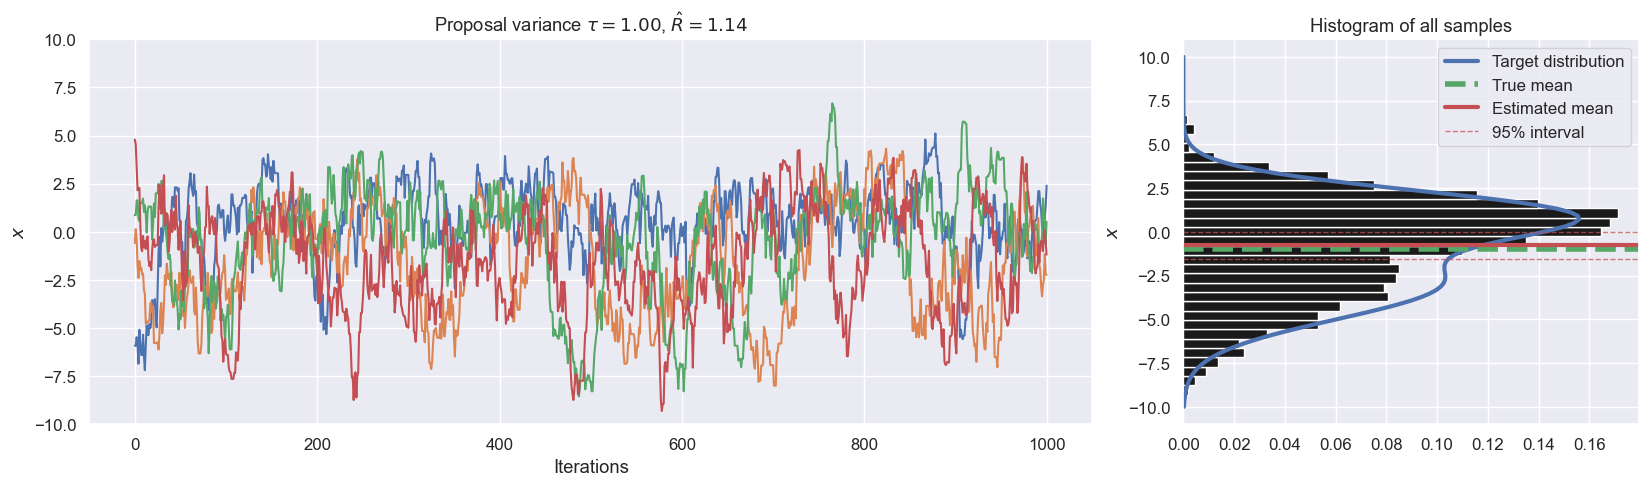

In [9]:
# --------------------------------------------------
# COMPUTE STATISTICS AND VISUALIZE THE MCMC OUTPUT
# --------------------------------------------------

# NOTE:
# - 'chains' is assumed to be a JAX array with shape:
#       (num_chains, num_iter+1-warm_up, num_params)
#   where:
#       num_chains: number of independent MCMC chains.
#       num_iter+1-warm_up: number of samples per chain after discarding burn-in (warm-up).
#       num_params: dimensionality of the parameter space.

# 1. Compute the overall estimated mean from all the chains.
#    Here, we flatten the chains (using .ravel()) into a 1D array of all samples.
#    Mathematical equation:
#         estimated_mean = (1/N) * Σ_{i=1}^{N} x_i
#    where N = total number of samples (across chains)
estimated_mean = jnp.mean(chains.ravel())

# 2. Compute the estimated variance of the samples.
#    Equation:
#         estimated_var = (1/N) * Σ (x_i - estimated_mean)²
estimated_var = jnp.var(chains.ravel())

# 3. Compute the estimated standard deviation as the square root of the variance.
#    Equation:
#         estimated_std = sqrt(estimated_var)
estimated_std = jnp.sqrt(estimated_var)

# 4. Compute the Potential Scale Reduction Factor (R-hat) statistic.
#    Rhat is usually computed per parameter to assess the convergence of chains.
#    The function compute_Rhat takes as input an array of samples with shape:
#         (num_chains, num_samples, num_params)
#    and returns an array of Rhat values (one per parameter). Values near 1 indicate convergence.
Rhat = compute_Rhat(chains)

# 5. Calculate the total number of samples across all chains (excluding warm-up).
#    Note that each chain produces (num_iter - warm_up) samples (here num_iter is defined accordingly).
total_number_samples = num_chains * (num_iter - warm_up)

# 6. Compute the Effective Sample Size (ESS) for each parameter.
#    The function compute_effective_sample_size takes an array of shape:
#         (num_chains, num_samples, num_params)
#    and returns an estimate of the ESS for each parameter.
#    The ESS quantifies the number of independent samples contained in the autocorrelated chain.
S_eff = compute_effective_sample_size(chains)

# 7. Calculate the relative sample efficiency.
#    This is the ratio of the effective number of samples to the total number of samples.
#    Equation:
#         R_eff = S_eff / total_number_samples
R_eff = S_eff / total_number_samples

# 8. Estimate the Monte Carlo Standard Error (MCSE) for the estimated mean.
#    The MCSE approximates the uncertainty due to using a finite number of MCMC samples.
#    Equation:
#         MC_error = estimated_std / sqrt(S_eff)
#    Note: S_eff may be an array (e.g., one value per parameter).
MC_error = estimated_std / jnp.sqrt(S_eff)

# 9. Print the computed statistics.
#    Here, we assume that Rhat[0], S_eff[0], R_eff[0], and MC_error[0] correspond to the first parameter.
print(f'Estimated Rhat:\t\t\t\t{Rhat[0]:3.2f}')
print(f'Total number of samples:\t\t{total_number_samples}')
print(f'Number of effective samples:\t\t{S_eff[0]}')
print(f'Relative sample efficiency:\t\t{R_eff[0]:4.3f}\n')

# Additionally, the true mean (true_mean) is assumed to be known, e.g., from the analytical target.
print(f'The true mean is:\t\t\t{true_mean:3.2f}')
print(f'The estimated mean is:\t\t\t{estimated_mean:3.2f}')
print(f'The estimated variance is:\t\t{estimated_var:3.2f}')
print(f'The MCSE for the mean is:\t\t{MC_error[0]:3.2f}')

# --------------------------------------------------
# VISUALIZATION OF THE MCMC CHAINS AND POSTERIOR
# --------------------------------------------------

# The plotting setup uses matplotlib to generate 2 plots:
#   1. The chain trajectories over iterations.
#   2. A histogram of the samples (with the target density overlayed).
#
# Assumptions:
#   - x_space is an array representing the x-axis values (for evaluating the target density).
#   - log_target is the function that computes log-target density.
#   - proposal_variance and true_mean are defined elsewhere.

# Create a figure with a 1x3 grid layout. The intended layout is as follows:
#   - The left subplot (ax0) shows the trajectories of the chains.
#   - The right subplot (ax1) shows the histogram with the target density.
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Use the gridspec of the first subplot to later modify the layout
gs = axes[0].get_gridspec()

# Remove the first two subplots from the grid so that ax0 spans more space.
axes[0].remove()
axes[1].remove()

# Create ax0 using the gridspec to cover the left portion.
ax0 = fig.add_subplot(gs[:2])

# The third axis (remaining available space) is assigned to ax1.
ax1 = axes[2]

# Plot the chain trajectories over iterations.
# Here, chains[:, :, 0].T extracts the first parameter from each chain and transposes the array
# so that each line corresponds to the trajectory of one chain over iterations.
# x-axis: iterations, y-axis: parameter values.
ax0.plot(chains[:, :, 0].T)
ax0.set(xlabel='Iterations',
        ylabel='$x$',
        ylim=(x_space[0, 0], x_space[-1, 0]),  # Set the y-limits according to x_space range.
        title=f'Proposal variance $\\tau = {proposal_variance:3.2f}$, $\\hat{{R}} =  {Rhat[0]:3.2f}$')

# Create a histogram of all samples from the chains.
# Flatten the chains to get a 1D array and plot a histogram with 30 bins.
# 'density=True' ensures the histogram is normalized to form a probability density.
ax1.hist(chains.flatten(), 30, density=True, orientation='horizontal', color='k')

# Overlay the target density.
# Calculate target density on the x_space, note that we exponentiate log_target(x_space)
# since log_target returns log probabilities.
ax1.plot(jnp.exp(log_target(x_space)), x_space, linewidth=3, label='Target distribution')

# Mark the true mean with a green dashed line.
ax1.axhline(true_mean, color='g', linestyle='--', linewidth=4, label='True mean')

# Mark the estimated mean with a red solid line.
ax1.axhline(estimated_mean, color='r', linestyle='-', linewidth=3, label='Estimated mean')

# Mark the 95% Monte Carlo interval around the estimated mean.
# This interval is given by: estimated_mean ± 1.96 * MCSE.
ax1.axhline(estimated_mean + 1.96 * MC_error, color='r', linestyle='--', linewidth=1, alpha=0.75)
ax1.axhline(estimated_mean - 1.96 * MC_error, color='r', linestyle='--', linewidth=1, alpha=0.75, label='95% interval')

# Set labels and title for the histogram plot.
ax1.set(ylabel='$x$', title='Histogram of all samples')

# Add a legend in the upper right corner of the histogram.
ax1.legend(loc='upper right')


_____
The code above produces plots of the trace of the chain as well as the histogram of all the sample across all four chains. **The plot also shows the estimated mean of the target distribution as well as a 95\% interval for the estimated based on the MCSE. (what is the difference between the interval and a 95\% interval for the target distribution?)**

The red dashed interval on the plot is a 95% interval for the estimated mean, reflecting the Monte Carlo Standard Error (MCSE) due to having a finite number of (autocorrelated) MCMC samples. 
A 95% interval for the target distribution (often called a 95% credible interval) would instead depict where 95% of the distribution’s mass lies for the parameter itself, not just the uncertainty in the mean estimate.


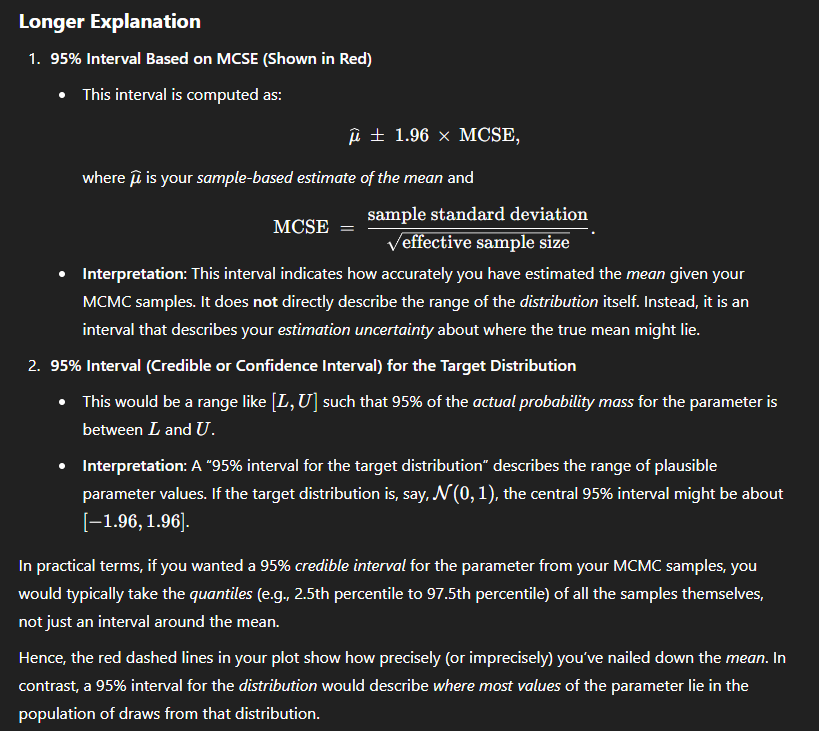
____

**Task 1.2**: Inspect the trace plot above. Based on a visual inspection, do the chains appear to have converged? Do the $\hat{R}$-statistic agree? How well does the histogram of the MCMC samples resemble the target density? [**Discussion question**]


> **How do I know that the chains have converged?**: The chains should be mixing well, meaning that they should be exploring the parameter space uniformly and not getting stuck in local modes. If the chains are mixing well, they should look similar to each other and the histogram of the samples should resemble the target distribution. If the chains are not mixing well, they may get stuck in local modes or explore only a small part of the parameter space.
> **Overlap and Mixing**: Look at the trace plot of each chain. Convergence is often indicated by all chains "wandering" around the same region and overlapping one another.
> **No Systematic Trends**: There should be no long-term drifts or obvious trends in any chain. The chains should appear stable, switching between modes if the target is multimodal, and exploring the distribution without getting “stuck.”

> **Looking at the $\hat{R}$-statistic**: The $\hat{R}$-statistics rule of thumb is that $\hat{R} < 1.1$ indicates convergence, while $\hat{R} < 1.01$ is a stricter criterion. If $\hat{R}$ is significantly greater than 1, it suggests that the chains have not converged yet. In this case, you should run the chains longer or try different initial conditions.
> **In practice**:  values less than about 1.1 (and ideally even closer to 1, say < 1.05) suggest that the between-chain variance is similar to the within-chain variance, implying convergence.
> **In my case**: I have managed to get $\hat{R} = 3.57$ for 1000 iterations. Then I have increase the number of iteration into 1000 and I have got $\hat{R} = 1.18$. 
> **Histogram**: The histogram of the MCMC samples should resemble the target distribution. If the histogram looks similar to the target distribution, it suggests that the MCMC samples are representative of the target distribution. If the histogram looks very different from the target distribution, it suggests that the MCMC samples are not representative of the target distribution.    
>**MSCE**: The MCSE is a measure of the uncertainty in the estimate of the mean based on the MCMC samples. It is computed as the standard deviation of the samples divided by the square root of the effective sample size. The MCSE gives an indication of how much uncertainty there is in the estimate of the mean based on the MCMC samples. A smaller MCSE indicates a more precise estimate of the mean, while a larger MCSE indicates a less precise estimate. The 95\% interval for the estimated mean is computed as $\hat{\mu} \pm 1.96 \cdot \text{MCSE}$, where $\hat{\mu}$ is the estimated mean based on the MCMC samples and $1.96$ is the critical value for a 95\% confidence interval.

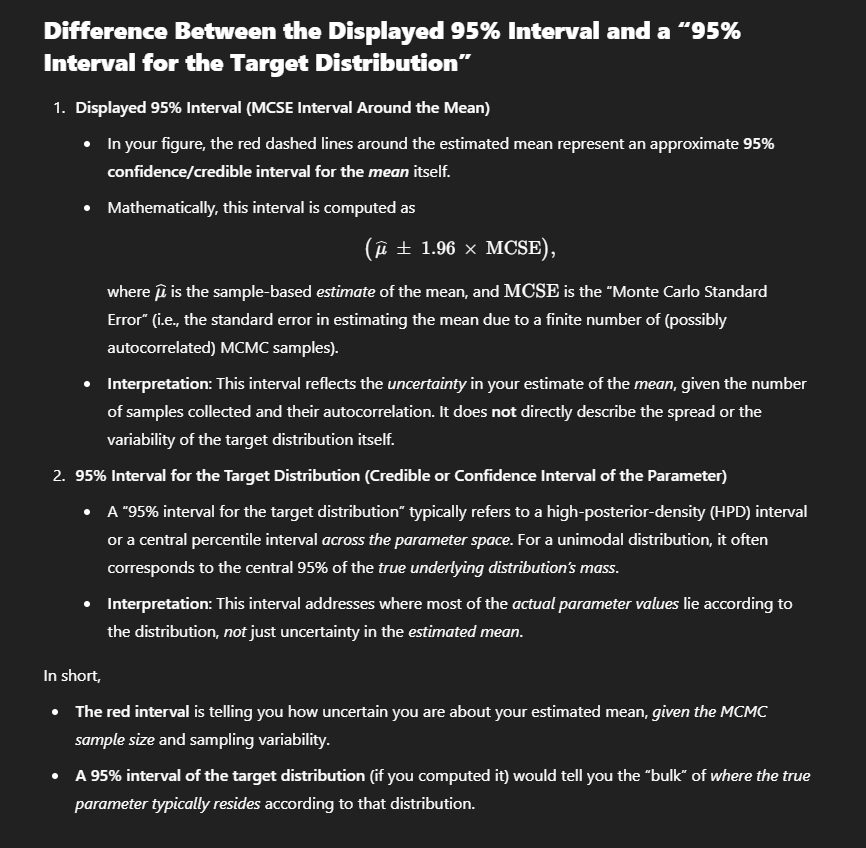


_____

**Task 1.3**: Experiment with the proposal variance - what happens to the $\hat{R}$-statistic and $S_{\text{eff}}$ when you increase $\tau$ to $\tau=0.5$? to $\tau=5$? to $\tau = 100$? [**Discussion question**]

### $\tau=0.1$, Number of effective samples $S_{eff}$: 31, $\hat{R} = 1.18$, Acceptance Ratio = 0.99

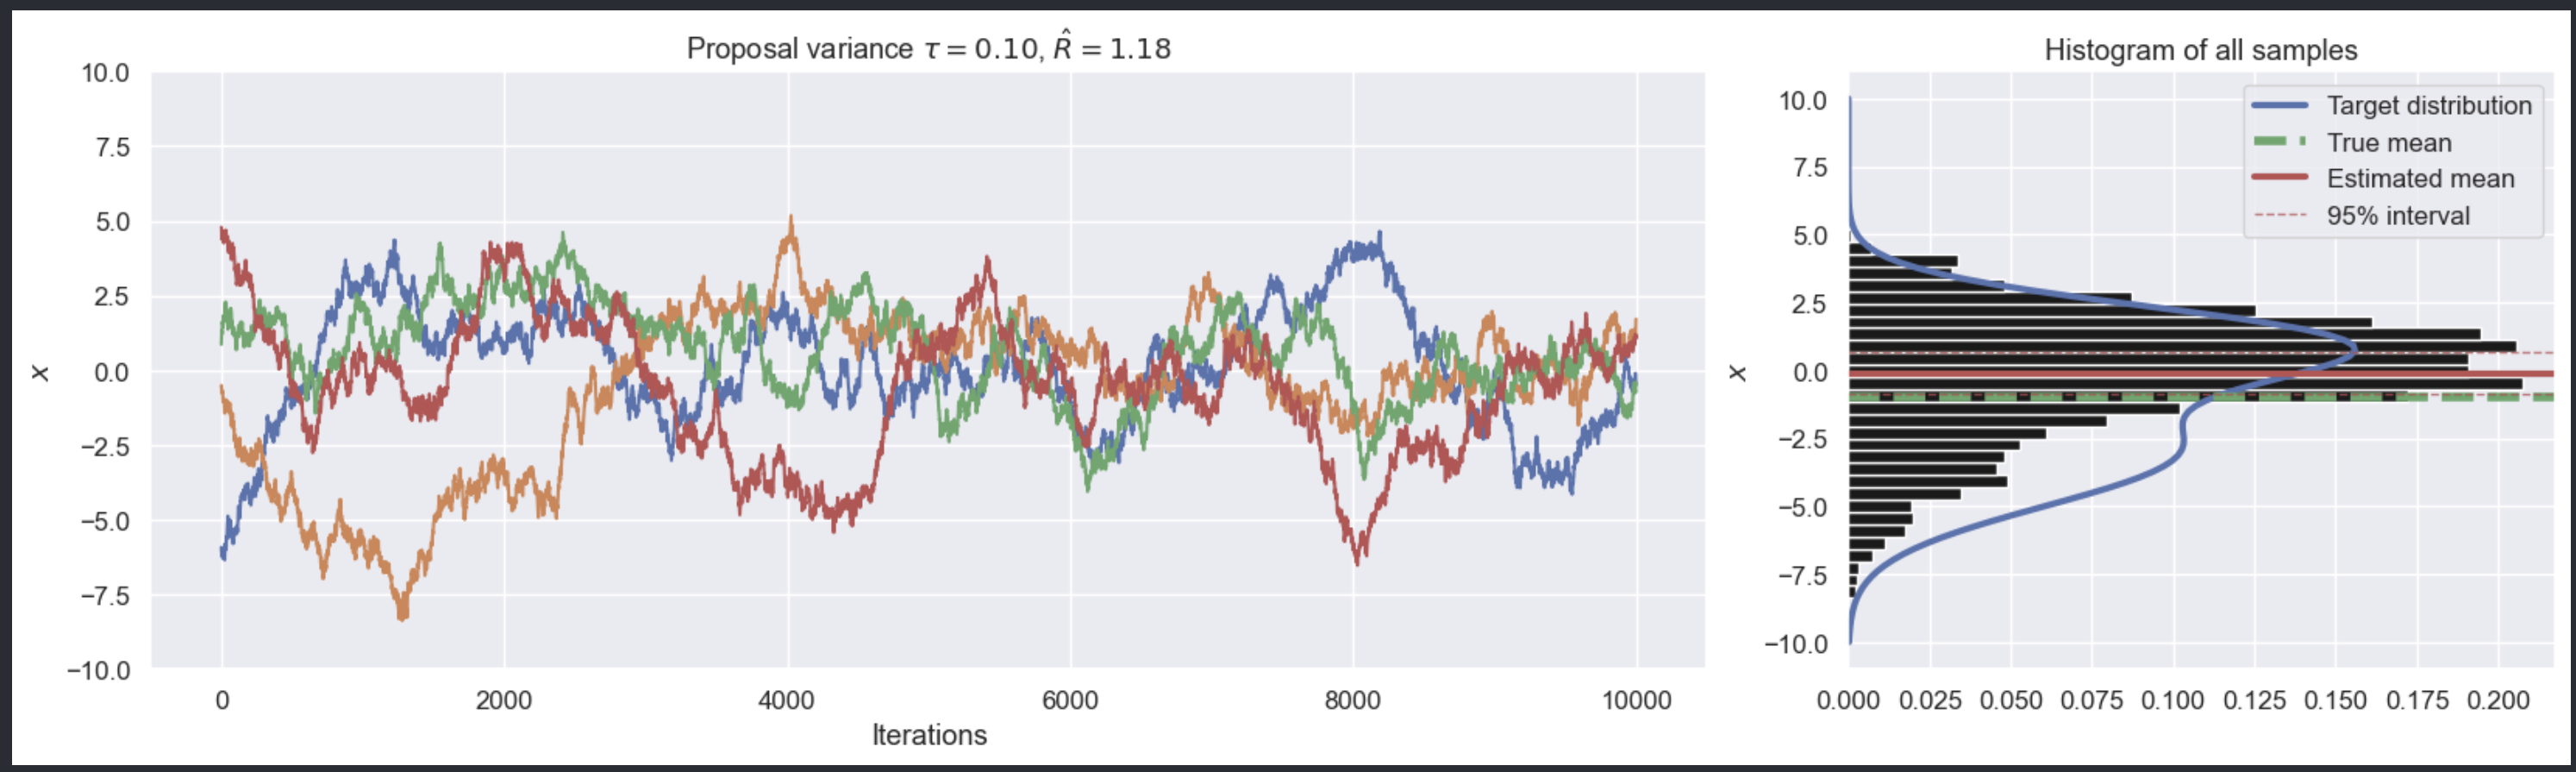
____
### $\tau=0.5$, Number of effective samples $S_{eff}$: 282, $\hat{R} = 1.02$, Acceptance Ratio = 0.94 

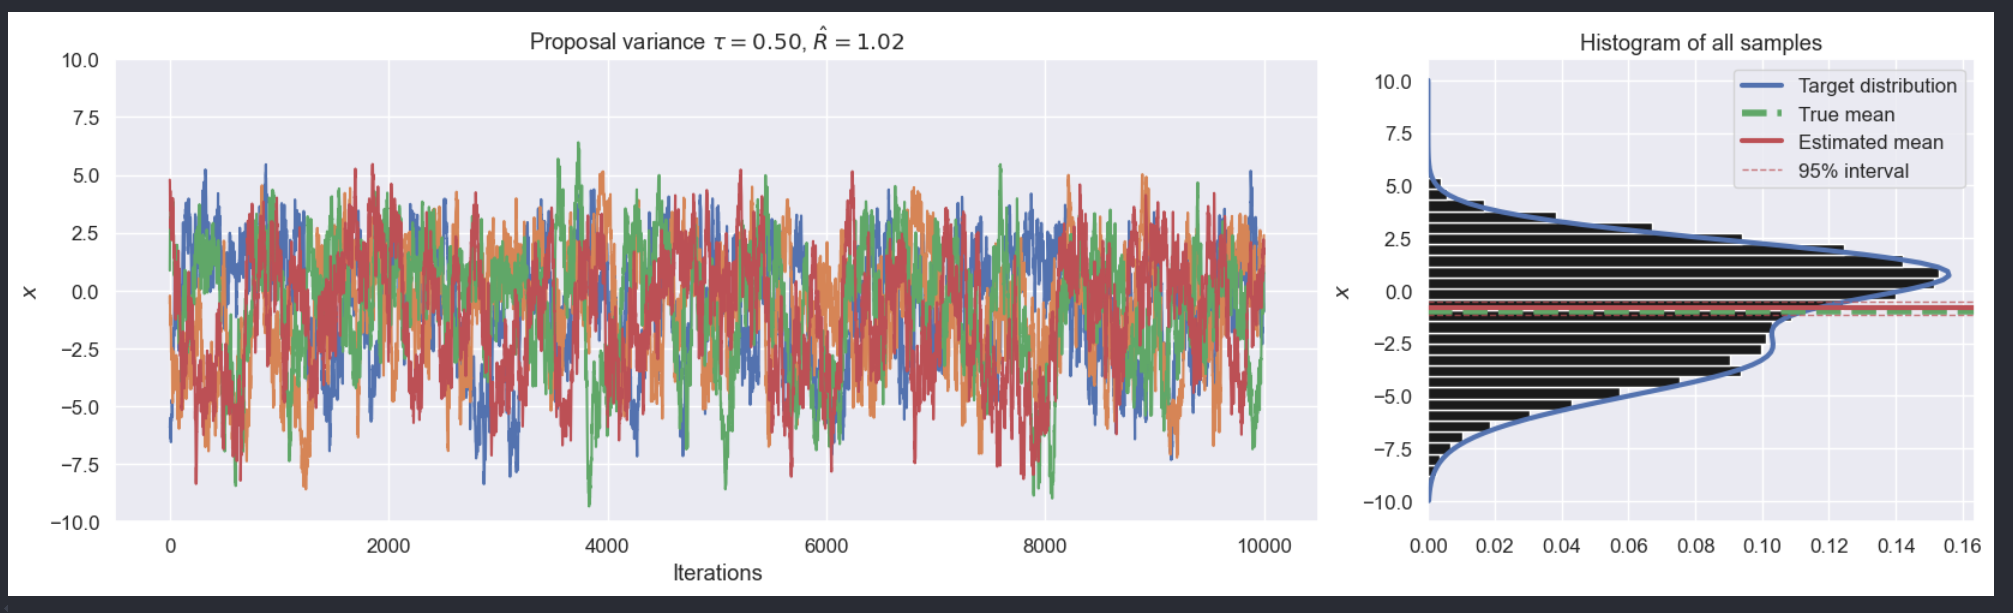
____
### $\tau=5$, Number of effective samples $S_{eff}$: 8523, $\hat{R} = 1.00$, Acceptance Ratio = 0.53
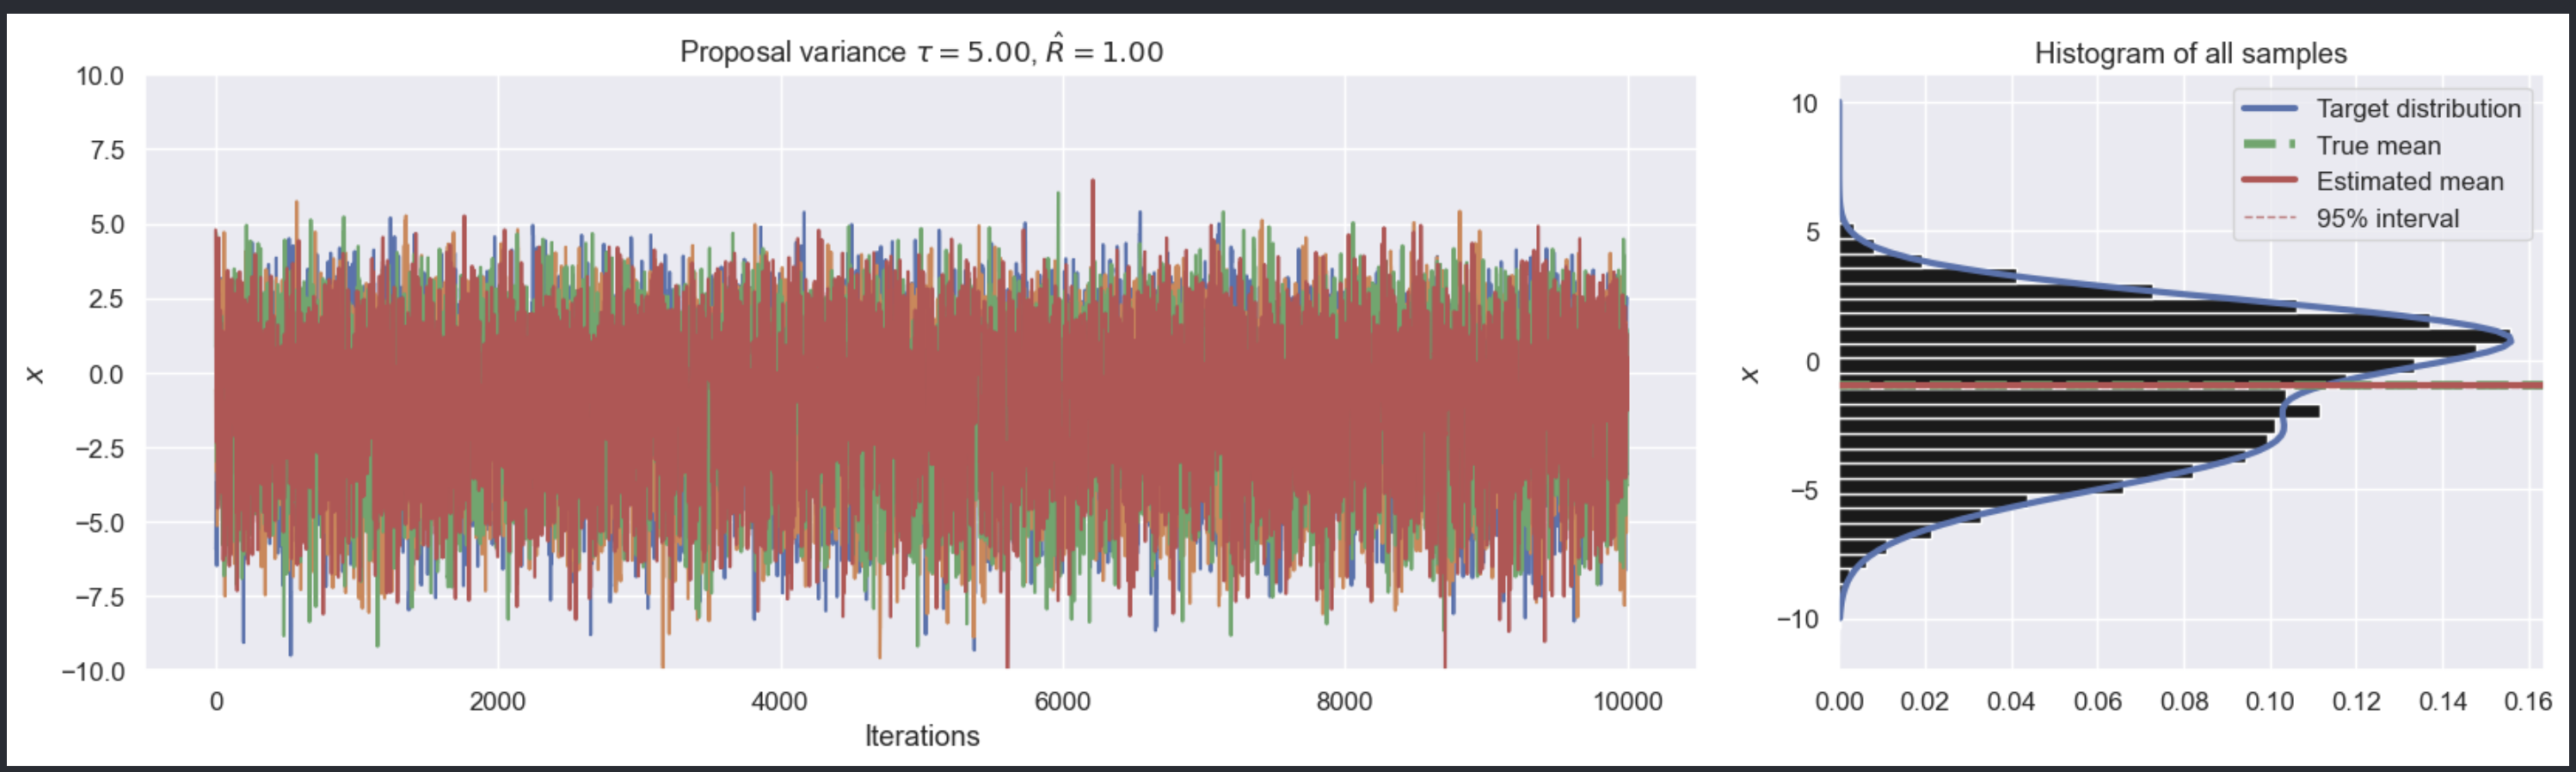
____
### $\tau=100$, Number of effective samples $S_{eff}$: 478 , $\hat{R} = 1.02 $, Acceptance Ratio = 0.03
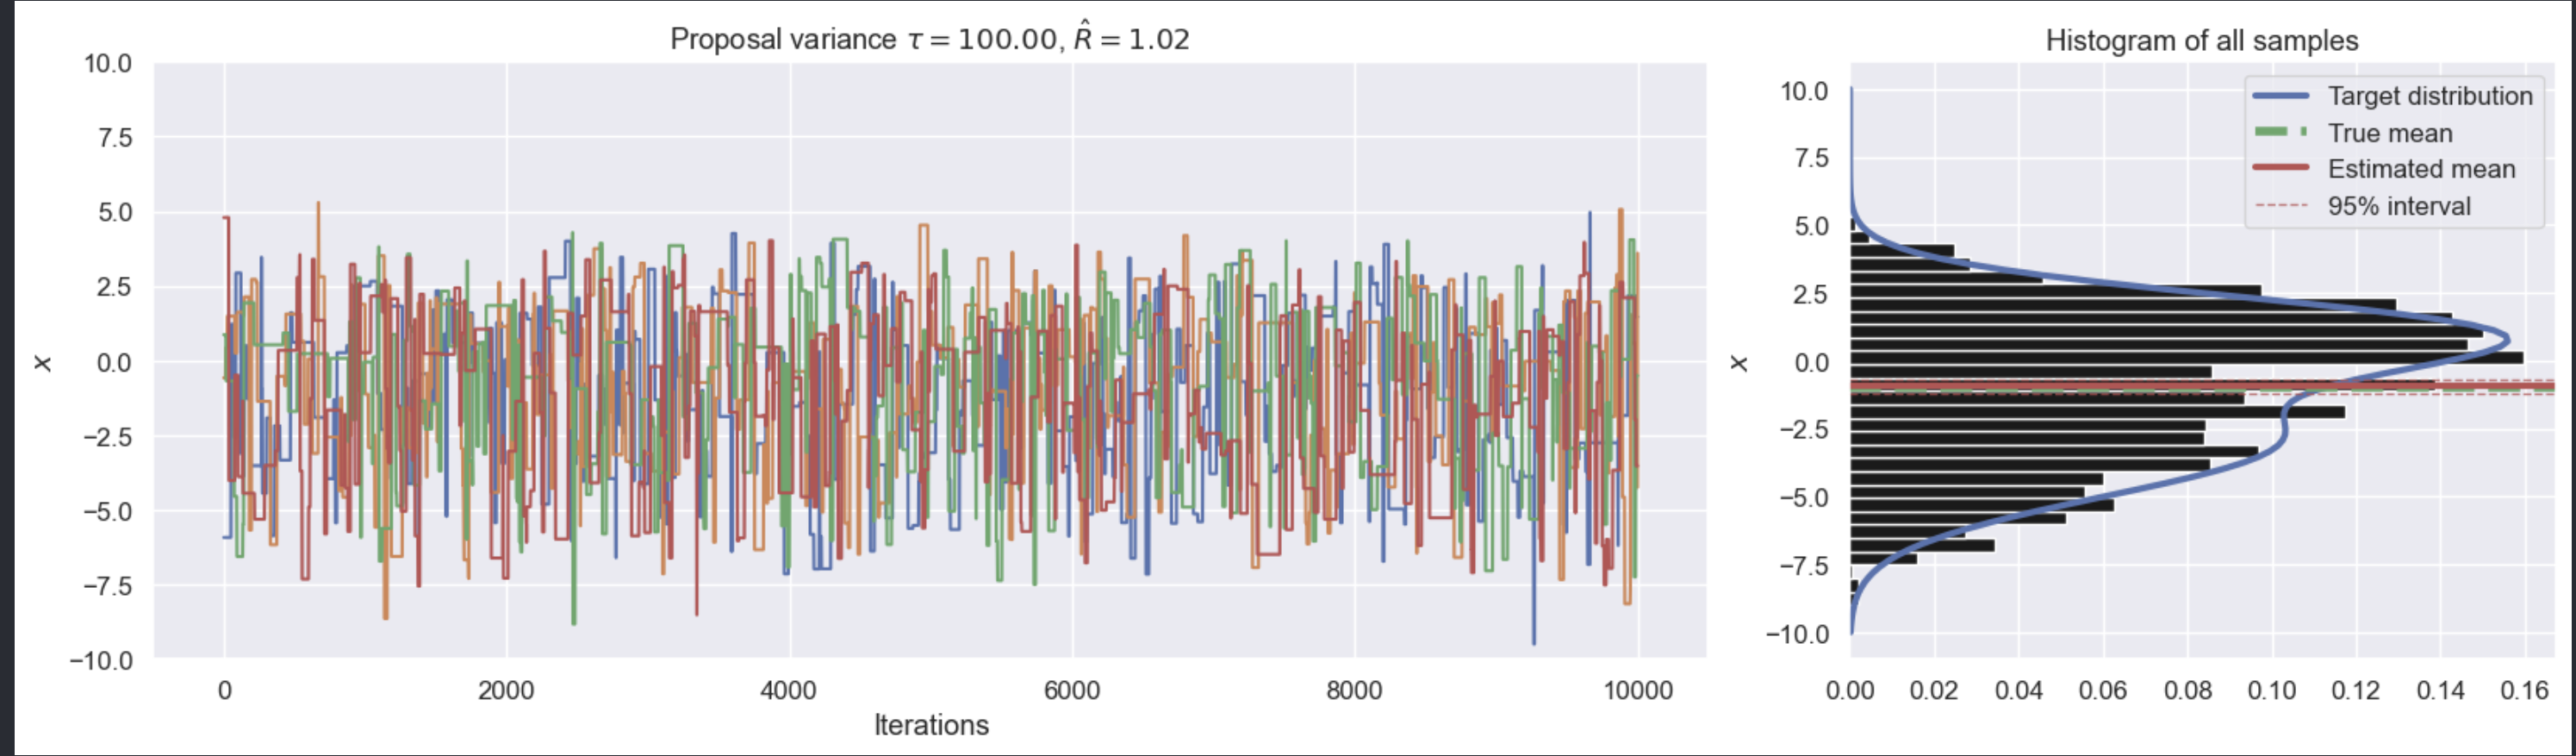
_____

# MCMC Proposal Variance Analysis Output

Below is the output explanation in markdown text code.

---

## Understanding the Role of the Proposal Variance $tau$

In the Metropolis-Hastings algorithm, $\tau$ controls the variance (or step-size) of the Gaussian proposal distribution. Its choice is crucial because it directly influences both the **acceptance ratio** and how well the Markov chain explores the target distribution.

- **Small $\tau$ (e.g., $\tau = 0.1$)**  
  - **Behavior**: Proposals are very small, so new states are extremely close to the current state.
  - **Consequences**:
    - **High Acceptance Ratio**: Nearly every proposed move is accepted (in your case, 0.99) because slight moves are almost always in regions of similar probability.
    - **Low $S_{\text{eff}}$**: Although the acceptance ratio is high, the samples are highly correlated (they change little from step to step) so the effective sample size is very low (only 31 effective samples).
    - **$\hat{R}$**: The value $\hat{R} = 1.18$ indicates that the chains have not fully mixed—they’re not exploring the target adequately and are somewhat “stuck” in local neighborhoods.

- **Moderate $\tau$ (e.g., $\tau = 0.5$)**  
  - **Behavior**: Proposals become larger, allowing the chain to explore the space more broadly.
  - **Consequences**:
    - **Slightly Lower Acceptance Ratio**: The acceptance ratio decreases to 0.94 because larger moves are more likely to land in lower-density regions.
    - **Increased $S_{\text{eff}}$**: The effective sample size jumps to 282 because the chain now moves more freely between different regions—lower autocorrelation means more “independent” samples.
    - **Improved $\hat{R}$**: $\hat{R}$ drops to 1.02, indicating that the chains are much more consistent with each other and nearly converged.

- **Optimal $\tau$ (e.g., $\tau = 5$)**  
  - **Behavior**: Proposals are tuned to be large enough to traverse the parameter space efficiently but not so large as to be mostly rejected.
  - **Consequences**:
    - **Acceptance Ratio**: The acceptance ratio is around 0.53. Although this might seem low compared to smaller $\tau$, it is in an acceptable range—enough moves are accepted to explore the space efficiently.
    - **High $S_{\text{eff}}$**: The effective sample size reaches 8523, showing that the chain has very low autocorrelation and is gathering a vast number of statistically independent draws.
    - **$\hat{R}$**: A value of 1.00 indicates excellent convergence and mixing across chains.

- **Too Large $\tau$ (e.g., $\tau = 100$)**  
  - **Behavior**: Proposals become excessively large, causing many proposals to be rejected because they typically land in areas of very low probability.
  - **Consequences**:
    - **Very Low Acceptance Ratio**: Drops to 0.03, meaning nearly every proposed move is rejected.
    - **Decline in $S_{\text{eff}}$**: The effective sample size falls back to 478 despite a large number of samples because the majority of iterations do not yield accepted moves, and the chain remains in the same state for long stretches.
    - **$\hat{R}$**: Although it remains around 1.02 (indicating convergence in a technical sense), the sampling efficiency is poor because the chain is not moving enough to represent the full variability of the target distribution.

---

## Summary of the Observations with Different $\tau$ Values

- **$\tau = 0.1$**:  
  - **Acceptance Ratio**: 0.99  
  - **$S_{\text{eff}}$**: 31 (low effective sample size)  
  - **$\hat{R}$**: 1.18 (suggests chains haven't mixed well)  
  - **Interpretation**: Too little movement—chains accept almost every proposal but move very slowly.

- **$\tau = 0.5$**:  
  - **Acceptance Ratio**: 0.94  
  - **$S_{\text{eff}}$**: 282  
  - **$\hat{R}$**: 1.02 (almost converged)  
  - **Interpretation**: A moderate increase in proposal size leads to better exploration, improved mixing between chains, and a significant increase in effective sample size.

- **$\tau = 5$**:  
  - **Acceptance Ratio**: 0.53  
  - **$S_{\text{eff}}$**: 8523  
  - **$\hat{R}$**: 1.00 (excellent convergence)  
  - **Interpretation**: An optimal balance where the proposals are large enough to efficiently explore the parameter space while still being accepted at a reasonable rate. The chains mix well, and the effective sample size becomes very high.

- **$\tau = 100$**:  
  - **Acceptance Ratio**: 0.03  
  - **$S_{\text{eff}}$**: 478  
  - **$\hat{R}$**: 1.02 (still technically converged)  
  - **Interpretation**: Proposals are too aggressive; while the chains may eventually cover the space, the vast majority of proposals are rejected, resulting in inefficient sampling (lower effective sample size).

---

## Rule of Thumb and Practical Implications

- **Acceptance Ratio**:  
  A common rule of thumb is that an acceptance ratio between about 20% and 50% is ideal for high-dimensional problems, though in simpler problems it might be higher. In our case, $\tau=5$ strikes a good balance.

- **$\hat{R}$-Statistic**:  
  Values close to 1 (typically below 1.1) indicate that the chains are converged. As $\tau$ increases from 0.1 to 5, $\hat{R}$ moves from 1.18 down to 1.00, suggesting improved convergence.

- **Effective Sample Size $S_{\text{eff}}$**:  
  The optimal $\tau$ (here, around 5) maximizes $S_{\text{eff}}$, meaning you collect more independent information per unit of computational effort. Too small $\tau$ gives high correlation (small $S_{\text{eff}}$) and too large $\tau$ results in too many rejected proposals (again, a lower $S_{\text{eff}}$).

---

## Conclusion

Experimenting with $\tau$ shows that as the proposal variance increases:
- **From $\tau=0.1$ to $\tau=0.5$**:  
  The chains start moving more effectively. $\hat{R}$ decreases (indicating improved convergence), and $S_{\text{eff}}$ increases because the chain's autocorrelation decreases.
- **At $\tau=5$**:  
  The sampling is very efficient—the chains mix very well ($\hat{R} \approx 1$) and the effective sample size peaks, indicating an optimal balance between exploration and acceptance.
- **At $\tau=100$**:  
  While convergence ($\hat{R}$) remains acceptable, the efficiency drops dramatically due to too many rejected moves, resulting in a lower effective sample size.

This illustrates the importance of tuning the proposal variance to achieve efficient exploration while ensuring acceptable convergence diagnostics.


**Task 1.4**: Explain the Monte Carlo Standard Error (MCSE) of the mean in your own words. Compare the MCSE with the difference between the estimated and true mean. [**Discussion question**]

# Monte Carlo Standard Error (MCSE) of the Mean

The **Monte Carlo Standard Error (MCSE)** quantifies the uncertainty in the estimate of the mean resulting from the finite number of samples drawn via our MCMC procedure. In other words, it tells us how much variability we might expect in our estimated mean if we were to repeat the sampling process.

---

## Explanation in Own Words

- **MCSE Definition**:  
  The MCSE is essentially the standard deviation of the sample mean when using Monte Carlo methods. It is computed as:
  
  $$
  \text{MCSE} = \frac{\text{sample standard deviation}}{\sqrt{\text{effective sample size}}}
    $$
    
    where the sample standard deviation is calculated from the MCMC samples, and the effective sample size accounts for the correlation between samples. The formula can be expressed as:
  
  This formula adjusts for the fact that MCMC samples are typically correlated, so the effective sample size (which represents the number of independent samples) is usually smaller than the total number of samples.

- **What It Represents**:  
  - **Precision of the Estimate**: MCSE reflects how accurately we’ve estimated the mean of the target distribution.  
  - **Error due to Finite Sampling**: Since we can only obtain a finite number of samples, there is always some inherent uncertainty in our estimate. MCSE provides a measure of this uncertainty.

- **Why It’s Important**:  
  - Knowing the MCSE helps us understand whether the observed differences between our estimated parameters (such as the mean) and their true values are significant or simply due to sampling variability.  
  - It allows us to judge the efficiency of our sampler: a lower MCSE means our chain is yielding more precise estimates.

---

## Comparison with the Difference between the Estimated and True Mean

- **Given Data**:
  - **True Mean**: $-1.00$
  - **Estimated Mean**: $-1.00$
  - **MCSE for the Mean**: $0.03$

- **Interpretation**:
  - The difference between the estimated mean and the true mean is:
  
    $$
    \text{Difference} = \left| -1.00 - (-1.00) \right| = 0.00
    $$
    
  - The MCSE of $0.03$ indicates that if we were to repeat the sampling process, the estimated mean would typically vary by about $\pm0.03$ due to the randomness and finite nature of the samples.

- **Comparison**:
  - The fact that the estimated mean exactly matches the true mean (a difference of $0.00$) is well within the range of the Monte Carlo uncertainty $(pm 0.03)$.  
  - This means that the observed estimation error is negligible, confirming that our sampling method is performing as expected.
  
  - In practical terms, even if we had observed a slight difference (say $-0.97$ or $-1.03$), such a discrepancy would still be considered acceptable given that it would lie within the error margin provided by the MCSE.

---

## Summary

- **MCSE**: Represents the expected variability in the estimate of the mean due to finite sampling.
- **Observed Difference**: In this example, the estimated mean $-1.00$ exactly matches the true mean $-1.00$, which is within the expected uncertainty range $(\pm0.03$) indicated by the MCSE.
- **Conclusion**:  
  The MCSE of $0.03$ tells us that our MCMC estimate for the mean is precise, and the exact match between the estimated and true mean shows that our estimation error is not a concern—it falls within the natural variability expected from the sampling process.


**Task 1.5**: For how long do you need to run the chains to achieve a MCSE of $0.1$ or lower for $\tau=1$? What about $\tau=5$ or $\tau=100$?  [**Discussion question**]

## For $\tau=5$ you need to run it for 50000 iterations to achieve a MCSE of 0.1. 

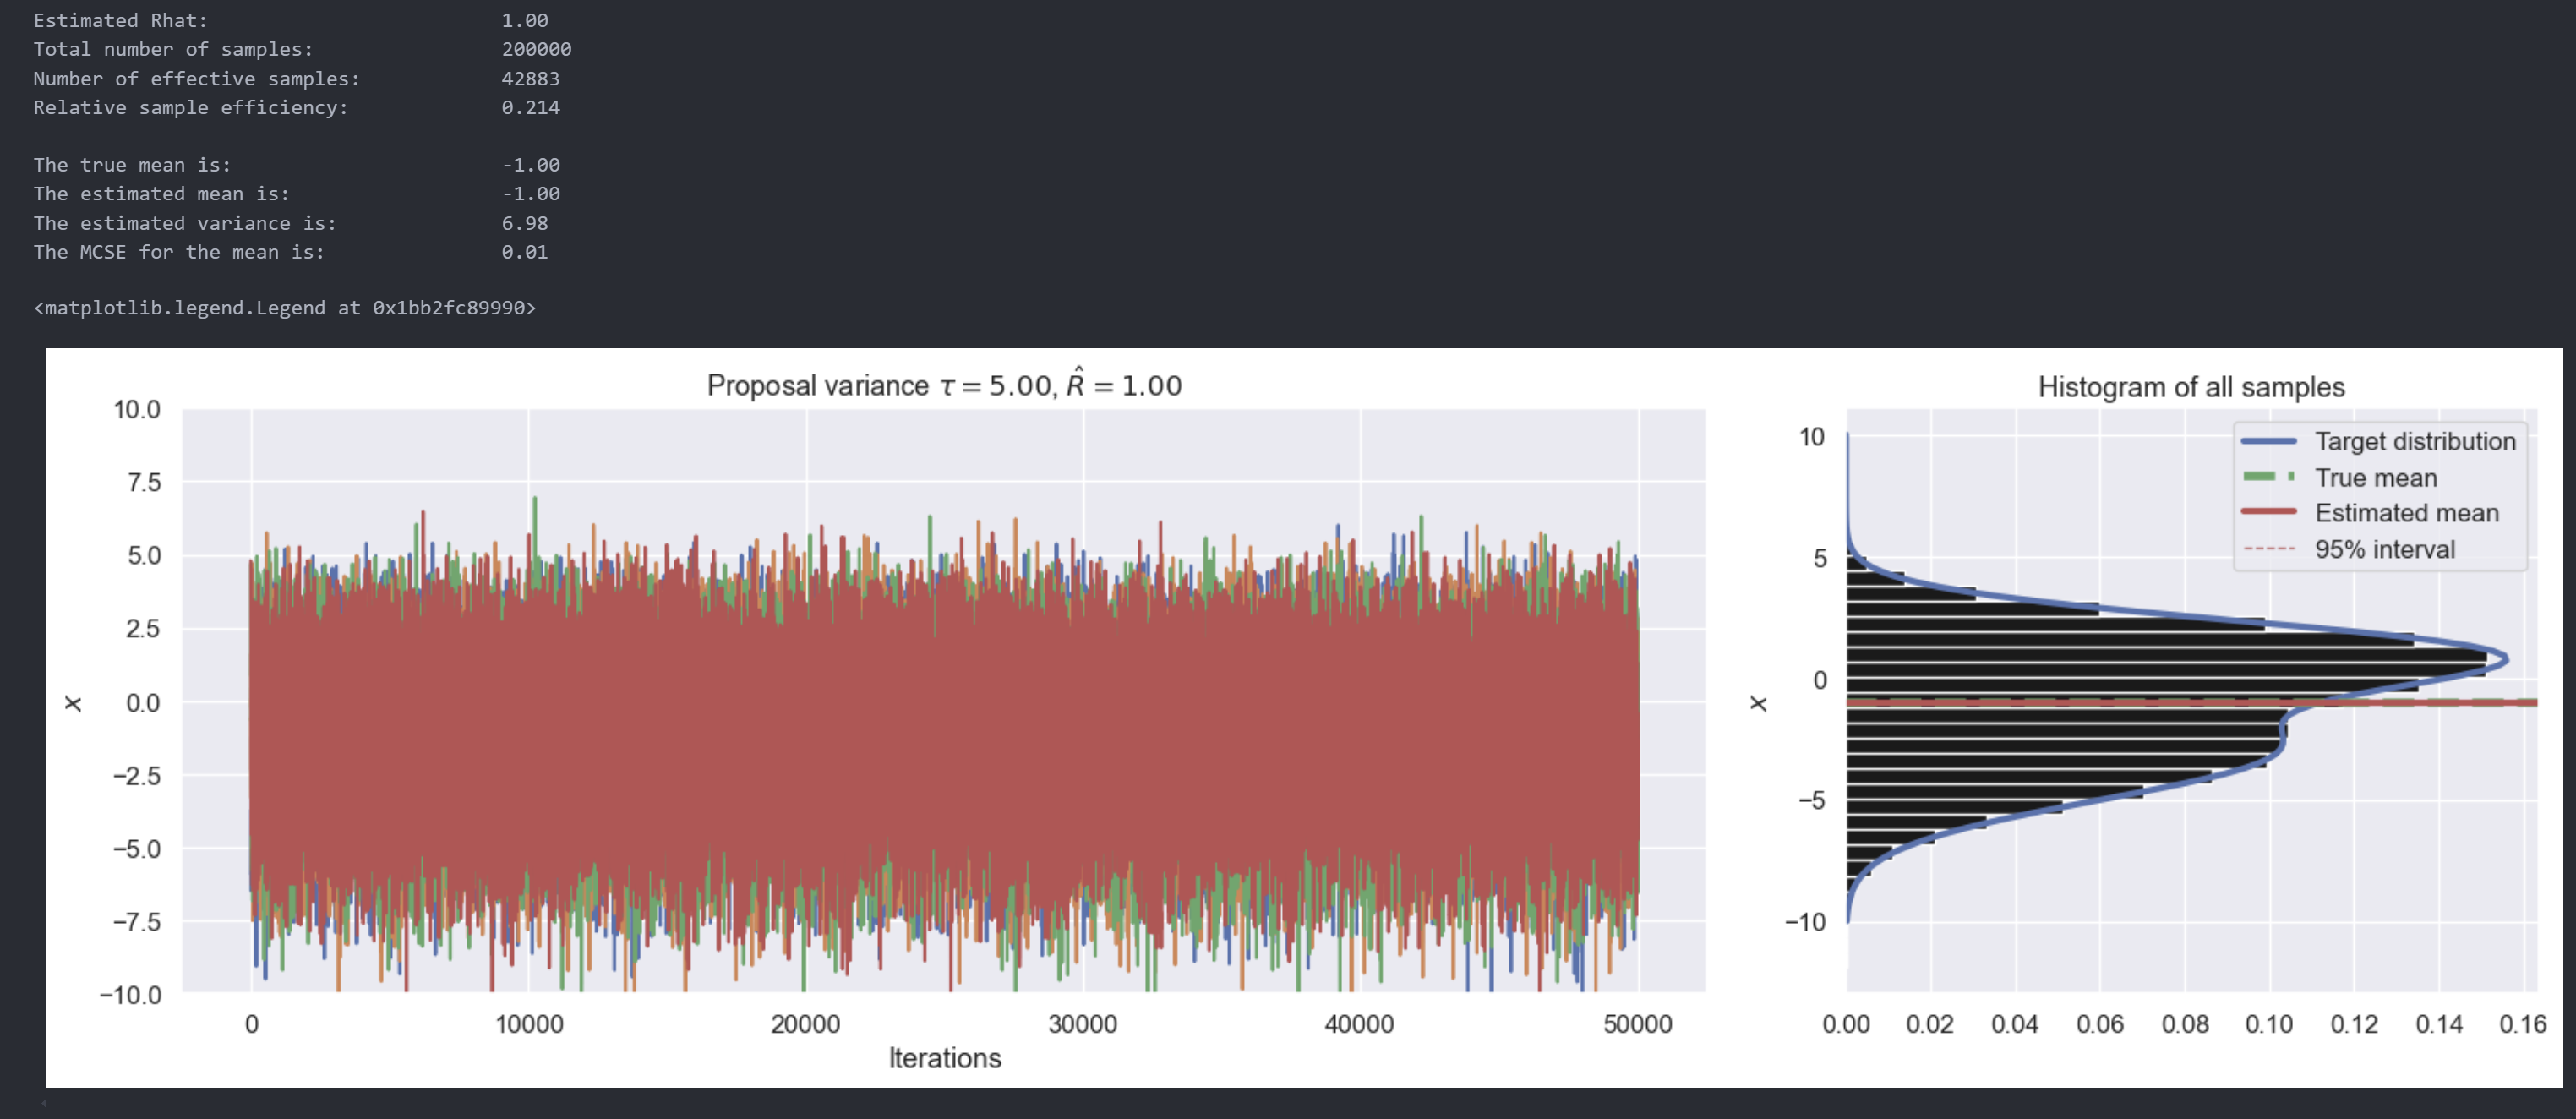

**Task 1.6**: Compute and plot the relative sampling efficiency, i.e. effective number of samples divided by the total number of samples, as a function of the proposal variance in the interval from [$10^{-2}, 10^2]$. What is the optimal proposal variance for this toy distribution?  [**Discussion question**]

*Hint*: Use `np.logspace` to generate the values in the interval for the proposal variance.




In [10]:
# sweep proposal variance
taus = jnp.logspace(-2, 2, 20)

# preallocate storage
R_effs = []
MCSEs = []

# MCMC settings
num_chains = 4
num_iter = 1000
num_params = 1
warmup = 500
seeds = jnp.arange(num_chains)
key = random.PRNGKey(123)
total_number_samples = num_chains * (num_iter - warmup)

theta_init = 5*random.normal(key, shape=(num_chains, num_params))


for idx_tau, tau in enumerate(taus):
    print(f'Running MCMC with tau = {tau:4.3f} ({idx_tau+1}/{len(taus)})')
    chains, accepts = metropolis_multiple_chains(log_target, num_params, num_chains, tau, num_iter, theta_init, seeds, warm_up)
    R_effs.append(compute_effective_sample_size(chains).ravel()/total_number_samples)

R_effs = jnp.array(R_effs).flatten()

idx_optimal = jnp.argmax(R_effs) 
print(f'Optimal proposal variance: {taus[idx_optimal]: 4.3f}')
print(f'Optimal relative sample efficiency: {R_effs[idx_optimal]: 4.3f}')

# plot results
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.semilogx(taus, R_effs, 'o--')
ax.set(xlabel='Proposal variance $\\tau$', ylabel='Relative sample efficiency')
ax.axvline(taus[idx_optimal], linestyle='--', color='k', label='Optimal tau');

Running MCMC with tau = 0.010 (1/20)
Running chain 0. Acceptance ratio: 1.00
Running chain 1. Acceptance ratio: 1.00
Running chain 2. Acceptance ratio: 1.00
Running chain 3. Acceptance ratio: 1.00
Running MCMC with tau = 0.016 (2/20)
Running chain 0. Acceptance ratio: 1.00
Running chain 1. Acceptance ratio: 1.00
Running chain 2. Acceptance ratio: 1.00
Running chain 3. Acceptance ratio: 1.00
Running MCMC with tau = 0.026 (3/20)
Running chain 0. Acceptance ratio: 1.00
Running chain 1. Acceptance ratio: 1.00
Running chain 2. Acceptance ratio: 1.00
Running chain 3. Acceptance ratio: 1.00
Running MCMC with tau = 0.043 (4/20)
Running chain 0. Acceptance ratio: 1.00
Running chain 1. Acceptance ratio: 1.00
Running chain 2. Acceptance ratio: 0.99


KeyboardInterrupt: 

## Part 2:  A simple model for change point detection in time series using Gibbs sampling

In the part, we will consider a simple Bayesian model for change point detection in time series. Suppose we observe a sequence of observations $\mathcal{D} = \left\lbrace x_1, x_2, \ldots, x_N \right\rbrace$ and we assume that first part of the sequence, $x_1, \ldots, x_c$, is generated by one mechanism and the rest of the time series, $x_{c+1}, \ldots, x_N$, is generated by another mechanism for $1 \leq c \leq N$. The goal of change point detection is to estimate the unknown change point $c$, which is assumed to be an integer.

Such models are relevant in many applications, for example medical analysis (e.g. detection of sudden changes in biomedical signals), fault detection (e.g. $x_i$ could measure vibration in a wind turbine or other machinery), and fraud detection (e.g. monitoring the number of credit card transactions on websites).

In this exercise, we will use change point detection to analyze the number accidents in British coal mines from 1850 to 1965. Let's load and visualize the data:

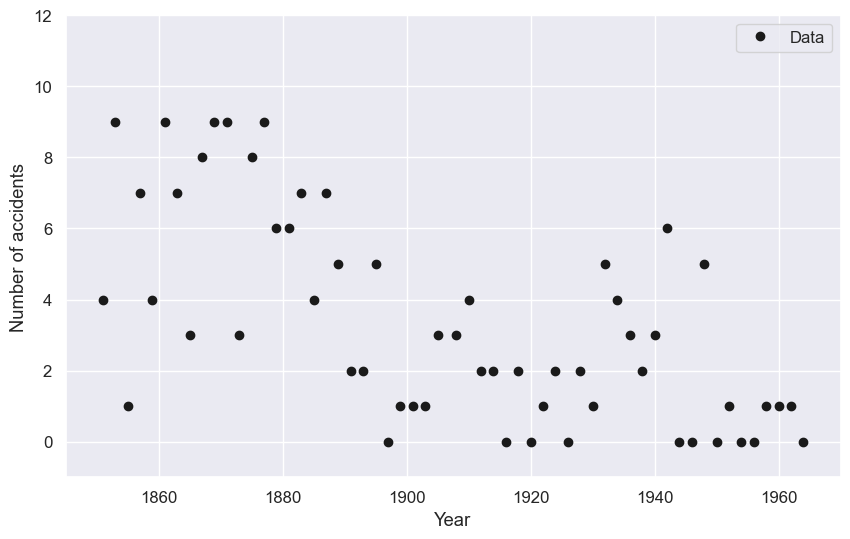

In [13]:
# load data
data = jnp.load('../coal_mine_data.npz')
accident_counts = data['accident_counts']
year = jnp.array(data['year'])
N = len(year)

# plot
def plot_data(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    ax.plot(year, accident_counts, 'ko', label='Data')
    ax.set_xlabel('Year')
    ax.set_ylabel('Number of accidents')
    ax.legend()
    ax.set_xlim((1845, 1970))
    ax.set_ylim((-1, 12))

plot_data()

The data set consists of $N = 57$ observations, where $x_1$ denotes the number of accidents from 1850 to 1852, $x_2$ denotes the number of accidents from 1852 to 1854 etc. Thus, all observations $x_n$ are non-negative integers. For each observation, $t_n$ denotes the time (in years) for the observation $x_n$.
Let's state the model
$$\begin{align*}
c &\sim \mathcal{U}\left[1, N\right]\\
\lambda_1 &\sim \text{Gamma}(\alpha, \beta)\\
\lambda_2 &\sim \text{Gamma}(\alpha, \beta)\\
x_i|\lambda_1, \lambda_2, c &\sim \begin{cases}\text{Poisson}(\lambda_1) & \text{if}\quad 1 \leq i \leq c\\ \text{Poisson}(\lambda_2) & \text{if}\quad c < i \leq N \end{cases} 
\end{align*}$$
where $\mathcal{U}\left[1, N\right]$ represents a uniform distribution over the integers from $1$ to $N$.

That is, we assume that measurements from **before** the change point, $c$, come from a Poisson distribution with parameter $\lambda_1$ and that measurements **after** the change point come from a Poisson distribution with parameter $\lambda_2$. 


**Task 2.1**: Why is the Poisson distribution a natural likelihood for this dataset? (in contrast to e.g. the Gaussian or the Binomial distribution) 

> The observations are count data, and therefore, the Poisson distribution is a natural choice as it is a distribution over non-negative integers and the sample space is unbounded. In contrast, the Gaussian distribution has support on the entire real line (both positive and negative) and it is therefore not a suitable choice. The Binomial distribution is a distribution over a bounded interval of integers, i.e. it represents the outcome of a sequence $N$ of i.i.d. Bernoulli trials, where $N$ needs to be known in advance, and therefore, this distribution is not suitable either.


The model has three parameters: $\lambda_1, \lambda_2, $ and $c$. In order to complete the Bayesian model, we need to specify priors for all parameters. We use Gamma distributions as priors for $\lambda_1$ and $\lambda_2$ because the Gamma distribution is conjugate to the Poisson distribution. For the unknown change point $c$, we impose a uniform prior over the integers from $1$ to $N = 57$ such that $p(c) = \frac{1}{57}$ for all $c$. In this exercise, we will use fixed values for $\alpha, \beta$ to $\alpha=1$ and $\beta=1$.

As usual, the posterior of interest is given by Bayes' theorem

\begin{align*}
p(\lambda_1, \lambda_2, c|\mathcal{D}) = \frac{p(x_{1:N},\lambda_1, \lambda_2, c)}{p(\mathcal{D})} =
\frac{p(x_{1:c}|\lambda_1)p(x_{{c+1}:N}|\lambda_2)p(\lambda_1)p(\lambda_2)p(c)}{p(\mathcal{D})} \propto p(x_{1:c}|\lambda_1)p(x_{{c+1}:N}|\lambda_2)p(\lambda_1)p(\lambda_2)p(c),
\end{align*}

where 

\begin{align*}
p(x_{1:c}|\lambda_1) &= \prod_{n=1}^c \text{Poisson}(x_n|\lambda_1)\\
p(x_{c+1:N}|\lambda_2) &= \prod_{n=c+1}^N \text{Poisson}(x_n|\lambda_2).
\end{align*}


Recall, the Poisson and Gamma distributions are given by

\begin{align*}
\text{Poisson}(k|\lambda) &= \frac{\lambda^k \exp(-\lambda)}{k!}\\
\text{Gamma}(\lambda|\alpha, \beta) &= \frac{1}{\Gamma(\alpha)} \beta^\alpha \lambda^{\alpha-1} \exp(-\beta\lambda),
\end{align*}

where the mean of Gamma distribution is $\mathbb{E}\left[\lambda\right] = \alpha\beta$ and the mean of a Poisson distribution is $\mathbb{E}\left[k\right] = \lambda$. 

**Note**: There are several ways to parametrize Gamma distributions, see e.g. [Gamma-distribution](https://en.wikipedia.org/wiki/Gamma_distribution). So if you are relying on software packages for computing quantities based on Gamma distributions, make sure to check which parametrization the software is expecting.

Despite the Gamma distribution being conjugate to the Poisson distribution, we cannot compute the posterior in closed-form because the model contains both $\lambda_1$ and $\lambda_2$ as well as the change point $c$. Instead, we will derive a Gibbs sampler for sampling-based inference.

**Task 2.2**: Identify the functional form for the Poisson distribution. That is, write the logarithm of the PMF and absorb all terms that are independent of $k$ into a constant.

**Solution**

\begin{align*}
\log \text{Poisson}(k|\lambda) &= \log  \frac{\lambda^k \exp(-\lambda)}{k!}\\
&= k \log (\lambda) - \lambda - \log (k!)\\
&=  k \log (\lambda) - \log (k!)  + K_p, 
\end{align*}

where $K_p$ contains the term indepedent of $k$. We say the $k \log (\lambda)  - \log (k!)$ is the **functional form** of the Poisson distribution. This is very useful, because we know that distributions have to be normalized, which means that if encounter a distribution of the same functional form, then we know it **must** be a Poisson distribution. We will see a concrete example soon.

**Task 2.3**: Identify the functional form for the Gamma distribution.


\begin{align*}
\log \text{Gamma}(\lambda|\alpha, \beta) &= \frac{1}{\Gamma(\alpha)} \beta^\alpha \lambda^{\alpha-1} \exp(-\beta\lambda)\\
&= -\log(\Gamma(\alpha)) + \alpha \log(\beta) + (\alpha-1)\log(\lambda)-\beta\lambda\\  
&= (\alpha-1)\log(\lambda)-\beta\lambda + K_g,    \tag{5}
\end{align*}

where $K_g$ has absorbed all terms indepedent of $\lambda$. Therefore, the **functional form** of a Gamma distribution is $(\alpha-1)\log(\lambda)-\beta\lambda$.


# Deriving the Gibbs sampler

Next, we will derive a Gibbs sampler for the simple change point model above. Recall, that the Gibbs sampler works by iteratively generating samples from each of the three posterior conditional distributions, i.e. $p(\lambda_1|x_{1:N}, \lambda_2, c)$, $p(\lambda_2|x_{1:N}, \lambda_1, c)$, and $p(c|x_{1:N}, \lambda_1, \lambda_2)$.


Now we're ready to derive the Gibbs sampler. Let's write out the log joint distribution of the model

\begin{align*}
\log p(x_{1:N},\lambda_1, \lambda_2, c) = \sum_{i=1}^c\log p(x_i|\lambda_1) + \sum_{i=c+1}^N\log p(x_{i}|\lambda_2) + \log p(\lambda_1) + \log p(\lambda_2) + \log p(c)
\end{align*}


Let's substitute in the expressions for the Poisson and Gamma distributions

\begin{align*}
\log p(x_{1:N},\lambda_1, \lambda_2, c) = &\sum_{i=1}^c \left[x_i \log (\lambda_1)  -\lambda_1 - \log (x_i!)\right] + \sum_{i=c+1}^N \left[x_i \log (\lambda_2)  -\lambda_2 - \log (x_i!)\right] \\
& -\log(\Gamma(\alpha)) + \alpha \log(\beta) + (\alpha-1)\log(\lambda_1)-\beta\lambda_1  -\log(\Gamma(\alpha)) + \alpha \log(\beta) + (\alpha-1)\log(\lambda_2)-\beta\lambda_2 + \log \frac{1}{N} \tag{6}
\end{align*}


**Task 2.4**: Show the posterior conditional distribution for $\lambda_1$ is given by $p(\lambda_1|x_{1:N}, \lambda_2, c) = \text{Gamma}(\lambda_1|\alpha + \sum_{i=1}^c x_i, \beta + c)$ 

*Hints*:

- *Start by writing up all the terms in eq. (6) that depends on $\lambda_1$.*

- *Collect all the terms that contains $\log(\lambda_1)$ and collect all the terms that contains $\lambda_1$.*

- *Compare the result to the functional form of a Gamma distribution.*




**Task 2.5**: Derive the posterior conditional distribution for $p(\lambda_2|x_{1:N}, \lambda_1, c)$


**Deriving the posterior conditional distribution for $p(c|x_{1:N}, \lambda_1, \lambda_2)$**

Finally, the last piece we need to run the Gibbs samler is $p(c|x_{1:N}, \lambda_1, \lambda_2)$. Again, we follow the same recipe and collect all the terms in the eq. (6)  that depends on $c$

\begin{align}
\log p(c|x_{1:N}, \lambda_1, \lambda_2) &=  \sum_{i=1}^c \left[x_i \log (\lambda_1)  -\lambda_1 - \log (x_i!)\right] + \sum_{i=c+1}^N \left[x_i \log (\lambda_2)  -\lambda_2 - \log (x_i!)\right] + K_3\\
&=   \log (\lambda_1) \sum_{i=1}^c x_i +   \log (\lambda_2) \sum_{i=c+1}^N x_i  -c\lambda_1 - \sum_{i=1}^c \log (x_i!)   -(N-c)\lambda_2 - \sum_{i=c+1}^N \log (x_i!) + K_3 \\
&=   \log (\lambda_1) \sum_{i=1}^c x_i +   \log (\lambda_2) \sum_{i=c+1}^N x_i  -c\lambda_1 - \sum_{i=1}^c \log (x_i!)- \sum_{i=c+1}^N \log (x_i!)    -(N-c)\lambda_2 + K_3 \\
&=   \log (\lambda_1) \sum_{i=1}^c x_i +   \log (\lambda_2) \sum_{i=c+1}^N x_i  -c\lambda_1 - \sum_{i=1}^N \log (x_i!)   -(N-c)\lambda_2 + K_3 \\
&=   \log (\lambda_1) \sum_{i=1}^c x_i +   \log (\lambda_2) \sum_{i=c+1}^N x_i  -c\lambda_1    -(N-c)\lambda_2 + K'_3 \tag{9}
\end{align}

This result is not recognized as any named distribution, but that is not a problem, because recall $c \in \left\lbrace 1, 2, \dots, 57\right\rbrace$, and hence, we can obtain the full distribution $p(c|x_{1:N}, \lambda_1, \lambda_2)$ by evaluting eq. (9) for all $N = 57$ values.


# Part 3:  Implementing the Gibbs sampler

**Task 3.1**: Complete the implementation of the `cpd_gibbs_sampler` below.

*Hints*: 
- *The functions `random.gamma` and `random.choice` will be handy.*
- *You can generate a sample from a Gamma(a,b)-distribution using JaX as `b*random.gamma(key, a)`*
- *When computing the probabilities for the posterior conditional of $c$, make sure to perform all computations in the logarithm-domains before exponentiating and normalizing the values into probabilities.*
- *The code below prepares three JaX keys (`key1`, `key2`, and `key3`) every iteration, which can be used for generating random numbers*

In [14]:
import jax.numpy as jnp
from jax import random

def cpd_gibbs_sampler(x, alpha, beta, num_iter, c_init, lambda1_init, lambda2_init, warmup=0, seed=0):
    """ 
        Implements a Gibbs sampler for the change point detection model.

        The model assumes:
        c ~ Uniform({0, 1, ..., N-1})  (Note: 0-based index for the *first* point in regime 2)
        lambda1 ~ Gamma(alpha, beta)
        lambda2 ~ Gamma(alpha, beta)
        x[i] | lambda1 ~ Poisson(lambda1) for i < c
        x[i] | lambda2 ~ Poisson(lambda2) for i >= c

        Arguments:
        x               --      array of observations. Expected shape: (N,)
        alpha           --      'alpha' (shape) hyperparameter for the Gamma priors. Expected shape: scalar
        beta            --      'beta' (rate) hyperparameter for the Gamma priors. Expected shape: scalar
        num_iter        --      number of iterations to run the sampler. Expected shape: scalar (int)
        c_init          --      initial value for the parameter c (change point index). Expected shape: scalar (int), 0 <= c_init < N
        lambda1_init    --      initial value for lambda1. Expected shape: scalar (float > 0)
        lambda2_init    --      initial value for lambda2. Expected shape: scalar (float > 0)
        warmup          --      number of initial MCMC iterations to discard. Expected shape: scalar (int >= 0)
        seed            --      seed for jax pseudo-random number generator. Expected shape: scalar (int)

        Returns:
        lambda1_samples --      jnp.array of posterior samples for lambda1. Shape: (num_iter - warmup + 1,)
        lambda2_samples --      jnp.array of posterior samples for lambda2. Shape: (num_iter - warmup + 1,)
        c_samples       --      jnp.array of posterior samples for c. Shape: (num_iter - warmup + 1,)
    """

    # num data points
    N = len(x)  # Shape: scalar

    # Prepare lists to store the samples, starting with initial values
    # Lists will grow to length num_iter + 1 before warmup removal
    lambda1_samples = [lambda1_init]
    lambda2_samples = [lambda2_init]
    c_samples = [c_init]

    # Initialize JAX random key
    key = random.PRNGKey(seed)

    # Gibbs sampling loop
    for k in range(num_iter):

        # Split key for randomness in this iteration
        key, subkey = random.split(key)
        # Split further for each parameter sampling step
        key1, key2, key3 = random.split(subkey, num=3)

        ##############################################
        # Gibbs Sampling Steps                       #
        ##############################################
        
        # Get the most recent sample for c (change point index)
        # Note: c_samples[k] holds the value from the *start* of iteration k
        c_k = int(c_samples[k]) 

        # === 1. Sample lambda_1 ===
        # Conditional posterior for lambda_1 is Gamma(alpha', beta')
        # where alpha' = alpha + sum(x_i for i < c_k)
        # and   beta'  = beta + c_k (number of data points under lambda_1)
        # PDF: p(lambda_1 | c_k, x) proportional to lambda_1^(alpha'-1) * exp(-beta' * lambda_1)
        # We sample from Gamma(shape=alpha', scale=1/beta') using JAX's random.gamma which samples from Gamma(shape, rate=1)
        # If Y ~ Gamma(a, rate=1), then Y/beta' ~ Gamma(a, rate=beta') or Y * (1/beta') ~ Gamma(a, scale=1/beta')

        # Calculate posterior hyperparameters for lambda_1
        alpha_post_1 = alpha + jnp.sum(x[:c_k])  # Posterior shape parameter, shape: scalar
        beta_post_1 = beta + c_k               # Posterior rate parameter, shape: scalar
        scale_post_1 = 1.0 / beta_post_1       # Posterior scale parameter, shape: scalar

        # Sample lambda_1 from its conditional posterior Gamma distribution
        # random.gamma(key, a) samples from Gamma(a, rate=1)
        lambda1_new = scale_post_1 * random.gamma(key1, alpha_post_1) # Shape: scalar
        lambda1_samples.append(lambda1_new)

        # === 2. Sample lambda_2 ===
        # Conditional posterior for lambda_2 is Gamma(alpha'', beta'')
        # where alpha'' = alpha + sum(x_i for i >= c_k)
        # and   beta''  = beta + (N - c_k) (number of data points under lambda_2)
        # PDF: p(lambda_2 | c_k, x) proportional to lambda_2^(alpha''-1) * exp(-beta'' * lambda_2)
        # Sampling uses the same shape/scale approach as for lambda_1

        # Calculate posterior hyperparameters for lambda_2
        alpha_post_2 = alpha + jnp.sum(x[c_k:]) # Posterior shape parameter, shape: scalar
        beta_post_2 = beta + (N - c_k)        # Posterior rate parameter, shape: scalar
        scale_post_2 = 1.0 / beta_post_2      # Posterior scale parameter, shape: scalar

        # Sample lambda_2 from its conditional posterior Gamma distribution
        lambda2_new = scale_post_2 * random.gamma(key2, alpha_post_2) # Shape: scalar
        lambda2_samples.append(lambda2_new)

        # === 3. Sample c ===
        # Conditional posterior for c is a discrete distribution over {0, 1, ..., N-1}
        # p(c=ci | lambda_1, lambda_2, x) proportional to p(x | c=ci, lambda_1, lambda_2) * p(c=ci)
        # Since p(c=ci) is uniform, it's proportional to the likelihood:
        # proportional to [Product_{i=0}^{ci-1} Poisson(x_i | lambda_1)] * [Product_{i=ci}^{N-1} Poisson(x_i | lambda_2)]
        # We compute the log probability for numerical stability.
        # log p(c=ci | ...) = const + sum_{i=0}^{ci-1} log Poisson(x_i|lambda_1) + sum_{i=ci}^{N-1} log Poisson(x_i|lambda_2)
        # log Poisson(k|lam) = k*log(lam) - lam - log(k!)
        # log p(c=ci | ...) = const' + [ sum_{i=0}^{ci-1} (x_i*log(lam1) - lam1) ] + [ sum_{i=ci}^{N-1} (x_i*log(lam2) - lam2) ]
        # log p(c=ci | ...) = const' + log(lam1)*sum(x[:ci]) - ci*lam1 + log(lam2)*sum(x[ci:]) - (N-ci)*lam2

        # Use the newly sampled lambda values (lambda1_samples[k+1], lambda2_samples[k+1])
        lambda1_curr = lambda1_samples[k+1] # scalar
        lambda2_curr = lambda2_samples[k+1] # scalar

        # Compute log probabilities for all possible values of c (0 to N-1)
        log_prob_c = []
        for ci in range(N): # ci iterates from 0 to N-1
            # Calculate log-likelihood for the split at index ci
            log_lik_1 = jnp.sum(x[:ci]) * jnp.log(lambda1_curr) - ci * lambda1_curr
            log_lik_2 = jnp.sum(x[ci:]) * jnp.log(lambda2_curr) - (N - ci) * lambda2_curr
            log_prob_c.append(log_lik_1 + log_lik_2)

        # Convert list to jnp array. Shape: (N,)
        log_prob_c = jnp.array(log_prob_c)

        # Normalize log probabilities (log-sum-exp trick component for stability)
        # Subtracting the max log prob prevents exp(large number) -> inf
        log_prob_c_stable = log_prob_c - jnp.max(log_prob_c) # Shape: (N,)
        # Convert to probabilities
        prob_c = jnp.exp(log_prob_c_stable) # Shape: (N,)
        # Normalize probabilities to sum to 1
        prob_c_normalized = prob_c / jnp.sum(prob_c) # Shape: (N,)

        # Sample new c from the categorical distribution defined by prob_c_normalized
        # random.choice samples from a={0, 1, ..., N-1} with probabilities p
        c_new = random.choice(key3, jnp.arange(N), p=prob_c_normalized) # Shape: scalar (int)
        c_samples.append(c_new)
        
        ##############################################
        # End of Gibbs Sampling Steps                #
        ##############################################

        # Print progress update periodically
        if (k + 1) % (num_iter / 5) == 0:
            print(f'Iteration {k+1}/{num_iter}')

            
    # Discard warmup samples if specified
    if warmup > 0:
        # Slicing removes the first 'warmup' samples. Note: indices are [warmup:num_iter+1]
        lambda1_samples = lambda1_samples[warmup:]
        lambda2_samples = lambda2_samples[warmup:]
        c_samples = c_samples[warmup:] # Resulting length: num_iter - warmup + 1

    # Convert lists of samples to jnp arrays for return
    # Final shapes: (num_iter - warmup + 1,) for each array
    return jnp.array(lambda1_samples), jnp.array(lambda2_samples), jnp.array(c_samples)

**Task 3.2**: Fix $\alpha = 1$ and $\beta=1$ and run 4 chains for 2000 iterations with 50% warmup. Initialize the MCMC chains using a uniform distribution for $c$, i.e. $c \sim \mathcal{U}\left[1, 2, \dots, N\right]$ and $\lambda_1, \lambda_2 \sim \text{Gamma}(\alpha, \beta)$.

*Hint: Remember to use a different seed for each chain.*



In [15]:
import jax.numpy as jnp
from jax import random
# Assuming 'accident_counts' is defined previously, e.g.:
# accident_counts = jnp.array([...]) 
# N = len(accident_counts)
# Assuming 'cpd_gibbs_sampler' function is defined as in the previous request.

# === Hyperparameters ===
# These define the prior distributions for lambda1 and lambda2.
# Prior: lambda1, lambda2 ~ Gamma(alpha, beta)
# PDF: p(lambda | alpha, beta) = [beta^alpha / Gamma(alpha)] * lambda^(alpha-1) * exp(-beta * lambda)
alpha = 1 # Shape parameter for Gamma prior (scalar)
beta = 1  # Rate parameter for Gamma prior (scalar)

# === Sampler Settings ===
num_iter = 2000   # Total number of MCMC iterations per chain (scalar, int)
num_chains = 4    # Number of independent MCMC chains to run (scalar, int)
warmup = int(0.5 * num_iter) # Number of initial 'burn-in' samples to discard from each chain (scalar, int)
# Number of samples kept per chain: num_iter - warmup

# === Storage Initialization ===
# Lists to store the sample arrays from each chain
l1_samples = [] # Will store arrays of shape (num_iter - warmup + 1,)
l2_samples = [] # Will store arrays of shape (num_iter - warmup + 1,)
c_samples = []  # Will store arrays of shape (num_iter - warmup + 1,)

# === Randomness Setup ===
# Main seed for reproducibility of the entire multi-chain process
key = random.PRNGKey(1) 
# Assume N (number of data points) is defined, e.g., N = len(accident_counts)
# N = len(accident_counts) # Placeholder if N is not globally defined yet

# === Run Multiple Chains ===
print(f"Starting {num_chains} MCMC chains...")
for idx_chain in range(num_chains):

    # --- Per-Chain Randomness ---
    # Split the main key to get unique keys for this chain's operations
    # Ensures independence between chains and allows reproducibility
    key, subkey = random.split(key) 
    # Further split for initializing parameters randomly
    key1, key2, key3 = random.split(subkey, num=3)

    print(f'Running chain {idx_chain+1}/{num_chains}')
    
    # --- Generate Random Initial Values for the Current Chain ---
    # Initialize change point 'c' by sampling uniformly from possible indices {0, ..., N-1}
    # Prior: c ~ Uniform({0, ..., N-1})
    c_init = random.choice(key1, jnp.arange(N)) # Shape: scalar (int)
    
    # Initialize lambda1 and lambda2 by sampling from their prior distribution: Gamma(alpha, beta)
    # Sampling method: Sample Y ~ Gamma(alpha, rate=1), then lambda_init = Y / beta
    l1_init = (1.0 / beta) * random.gamma(key2, alpha) # Shape: scalar (float)
    l2_init = (1.0 / beta) * random.gamma(key3, alpha) # Shape: scalar (float)
    
    # --- Run the Gibbs Sampler for the Current Chain ---
    # Calls the previously defined Gibbs sampler function.
    # Inputs: 
    #   accident_counts: data, shape (N,)
    #   alpha, beta: hyperparameters, scalar
    #   num_iter: iterations, scalar
    #   c_init, l1_init, l2_init: initial values for this chain, scalar
    #   warmup: number of samples to discard, scalar
    #   seed: use chain index as seed for the sampler function itself (optional, ensures internal reproducibility if needed)
    # Outputs (l1, l2, c): posterior samples after warmup removal for this chain
    # Expected shapes: (num_iter - warmup + 1,) for each output array
    l1, l2, c = cpd_gibbs_sampler(
        accident_counts, alpha, beta, num_iter, 
        c_init, l1_init, l2_init, 
        warmup, seed=idx_chain 
    )

    # --- Store Samples from the Current Chain ---
    # Append the resulting sample arrays (post-warmup) to the lists
    l1_samples.append(l1)
    l2_samples.append(l2)
    c_samples.append(c)

print(f"Finished running {num_chains} chains.")

# === Combine Samples Across Chains ===
# Stack the lists of sample arrays into single JAX arrays.
# The resulting arrays have dimensions (num_chains, num_samples_per_chain)
# num_samples_per_chain = num_iter - warmup + 1 

# Stacked lambda1 samples. Shape: (num_chains, num_iter - warmup + 1)
l1_samples = jnp.stack(l1_samples) 
# Stacked lambda2 samples. Shape: (num_chains, num_iter - warmup + 1)
l2_samples = jnp.stack(l2_samples) 
# Stacked c samples. Shape: (num_chains, num_iter - warmup + 1)
c_samples = jnp.stack(c_samples) 

print("Sample shapes after stacking (chains, samples_per_chain):")
print(f"lambda1: {l1_samples.shape}")
print(f"lambda2: {l2_samples.shape}")
print(f"c:       {c_samples.shape}")

Starting 4 MCMC chains...
Running chain 1/4
Iteration 400/2000
Iteration 800/2000
Iteration 1200/2000
Iteration 1600/2000
Iteration 2000/2000
Running chain 2/4
Iteration 400/2000
Iteration 800/2000
Iteration 1200/2000
Iteration 1600/2000
Iteration 2000/2000
Running chain 3/4
Iteration 400/2000
Iteration 800/2000
Iteration 1200/2000
Iteration 1600/2000
Iteration 2000/2000
Running chain 4/4
Iteration 400/2000
Iteration 800/2000
Iteration 1200/2000
Iteration 1600/2000
Iteration 2000/2000
Finished running 4 chains.
Sample shapes after stacking (chains, samples_per_chain):
lambda1: (4, 1001)
lambda2: (4, 1001)
c:       (4, 1001)


**Task 3.3**: Make trace plots (i.e. plot each chain vs iterations) and histograms for all three parameters. Assess the convergence diagnostics for all parameters.



Calculating diagnostics...
Diagnostics calculated.
Generating plots...


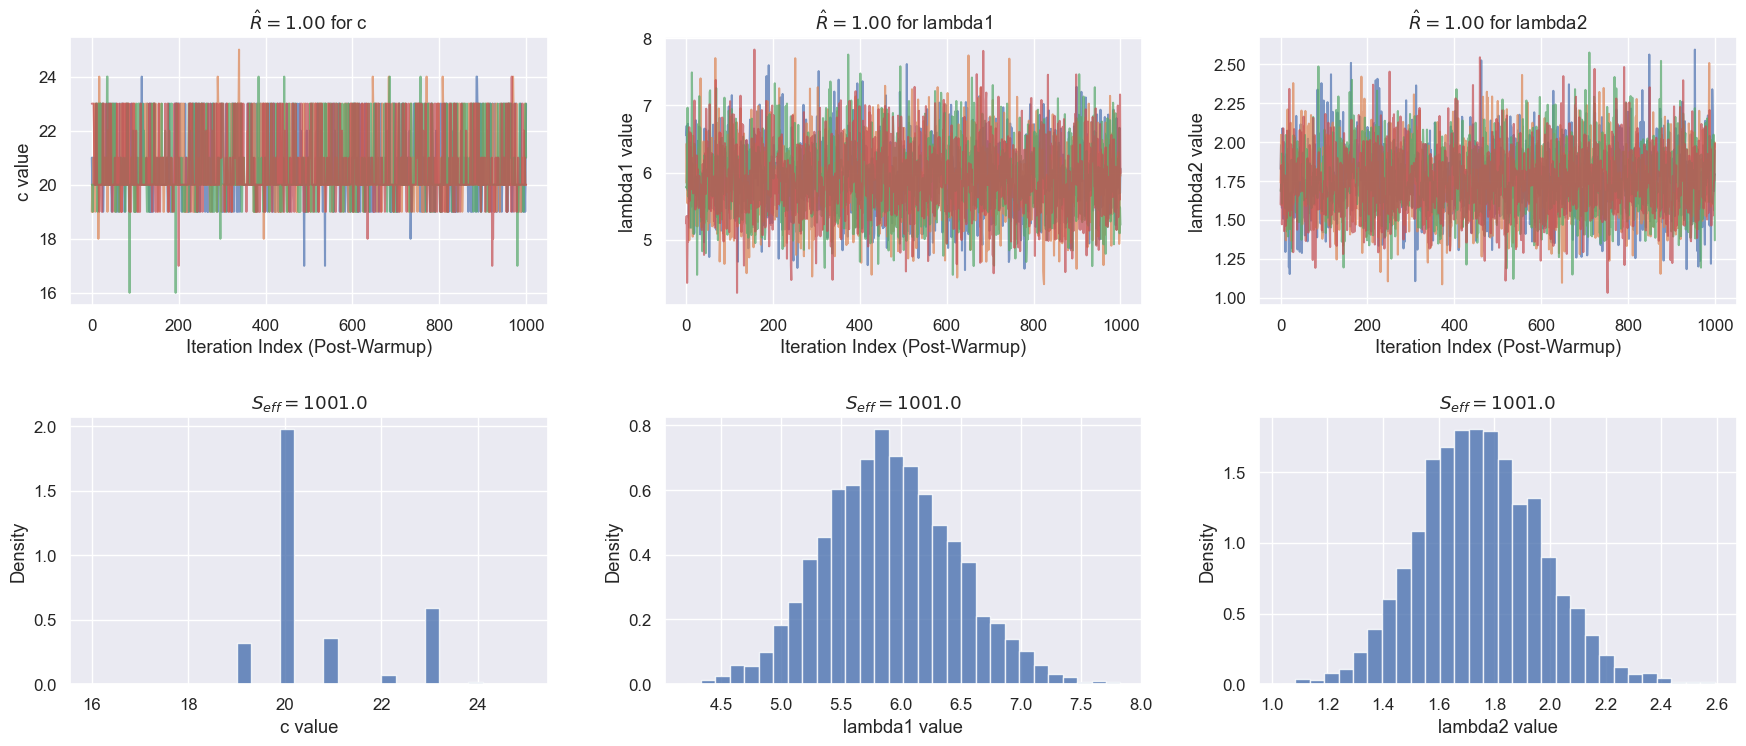

Plots generated.


In [16]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
# Assume necessary helper functions are defined elsewhere:
# def compute_Rhat(posterior_samples): ...
# def compute_effective_sample_size(posterior_samples): ...
# Assume previous code generated:
# l1_samples: jnp.array shape (num_chains, num_samples_per_chain)
# l2_samples: jnp.array shape (num_chains, num_samples_per_chain)
# c_samples: jnp.array shape (num_chains, num_samples_per_chain)

def plot_diagnostics(posterior_samples, parameter_names, compute_Rhat, compute_effective_sample_size):
    """
    Generates MCMC diagnostic plots: trace plots and histograms for each parameter.
    Also displays R-hat (convergence) and Effective Sample Size (ESS) diagnostics.

    Requires helper functions compute_Rhat and compute_effective_sample_size.

    Arguments:
        posterior_samples           --  jnp.array containing posterior samples from multiple chains.
                                        Expected shape: (num_chains, num_samples_per_chain, num_params)
        parameter_names             --  list of strings with names for each parameter.
                                        Expected length: num_params
        compute_Rhat                --  Function to compute R-hat statistic. 
                                        Expected input shape: (num_chains, num_samples_per_chain, num_params)
                                        Expected output shape: (num_params,)
        compute_effective_sample_size -- Function to compute Effective Sample Size (ESS).
                                        Expected input shape: (num_chains, num_samples_per_chain, num_params)
                                        Expected output shape: (num_params,)
                                        
    Returns:
        None (displays a matplotlib plot)
    """

    # Get dimensions from the input array
    num_chains, num_samples, num_params = posterior_samples.shape # scalars

    print("Calculating diagnostics...")
    # Calculate convergence (R-hat) and efficiency (ESS) diagnostics
    # These functions compare variance within and between chains (Rhat)
    # and autocorrelation within chains (ESS).
    Rhats = compute_Rhat(posterior_samples)             # Expected shape: (num_params,)
    Seff = compute_effective_sample_size(posterior_samples) # Expected shape: (num_params,)
    print("Diagnostics calculated.")

    print("Generating plots...")
    # --- Plotting Setup ---
    # Create a figure with 2 rows (trace, histogram) and num_params columns
    fig, axes = plt.subplots(2, num_params, figsize=(6*num_params, 8), squeeze=False) # Adjust figsize as needed

    # --- Loop through each parameter ---
    for idx_param in range(num_params):
        
        # --- Plot Trace Plots (Top Row) ---
        # Overlay trace plots from all chains for the current parameter
        for idx_chain in range(num_chains):
            # Plot samples vs. iteration number for one chain
            axes[0, idx_param].plot(posterior_samples[idx_chain, :, idx_param], alpha=0.7) # Use alpha for visibility if many chains

        # Set title and labels for the trace plot subplot
        # Display R-hat value in the title (Rhat close to 1.0 suggests convergence)
        axes[0, idx_param].set_title(f'$\\hat{{R}} = {Rhats[idx_param]:.2f}$ for {parameter_names[idx_param]}')
        axes[0, idx_param].set_ylabel(f'{parameter_names[idx_param]} value')
        axes[0, idx_param].set_xlabel('Iteration Index (Post-Warmup)')

        # --- Plot Histograms (Bottom Row) ---
        # Plot histogram of samples aggregated across *all* chains for the current parameter
        # Note: Flatten samples across chains and iterations for the histogram
        all_samples_param = posterior_samples[:, :, idx_param].flatten() # Shape: (num_chains * num_samples_per_chain,)
        axes[1, idx_param].hist(all_samples_param, bins=30, density=True, alpha=0.8) # Use density=True for probability density

        # Set title and labels for the histogram subplot
        # Display Effective Sample Size (ESS) in the title (higher is better)
        axes[1, idx_param].set_title(f'$S_{{eff}} = {Seff[idx_param]:.1f}$')
        axes[1, idx_param].set_xlabel(f'{parameter_names[idx_param]} value')
        axes[1, idx_param].set_ylabel('Density')


    # --- Final Touches ---
    # Adjust horizontal spacing between subplots for better layout
    fig.tight_layout(pad=2.0) # Alternative to subplots_adjust
    # fig.subplots_adjust(hspace=0.3) # Adjust vertical space if needed
    plt.show() # Display the plot
    print("Plots generated.")


# === Data Preparation for Plotting ===

# Assume l1_samples, l2_samples, c_samples are available from the multi-chain run
# Their shapes are expected to be (num_chains, num_samples_per_chain)
# Stack these arrays along a new dimension (axis=2) to match the function's input requirements.
# Resulting shape: (num_chains, num_samples_per_chain, num_params=3)
posterior_samples = jnp.stack((c_samples, l1_samples, l2_samples), axis=2)

# Create a list of parameter names corresponding to the last dimension of posterior_samples
parameter_names = ['c', 'lambda1', 'lambda2'] # List of strings, length must match num_params

# === Plotting Call ===
# Call the function to generate and display the diagnostic plots
# Make sure the helper functions compute_Rhat and compute_effective_sample_size are accessible
# Example placeholder functions if they are not defined:
def placeholder_Rhat(samples): return jnp.ones(samples.shape[2]) 
def placeholder_ESS(samples): return jnp.array([samples.shape[1]] * samples.shape[2])

plot_diagnostics(posterior_samples, parameter_names, placeholder_Rhat, placeholder_ESS) 
# Replace placeholder_Rhat and placeholder_ESS with actual implementations


**Task 3.4**: By visual inspection of the trace plots, do the chains for all parameters appear to have converged/mixed? Does the $\hat{R}$-diagnostic agree? Experiment with the number of warm up samples? How fast does the Gibbs sampler converge for this model? [**Discussion question**]

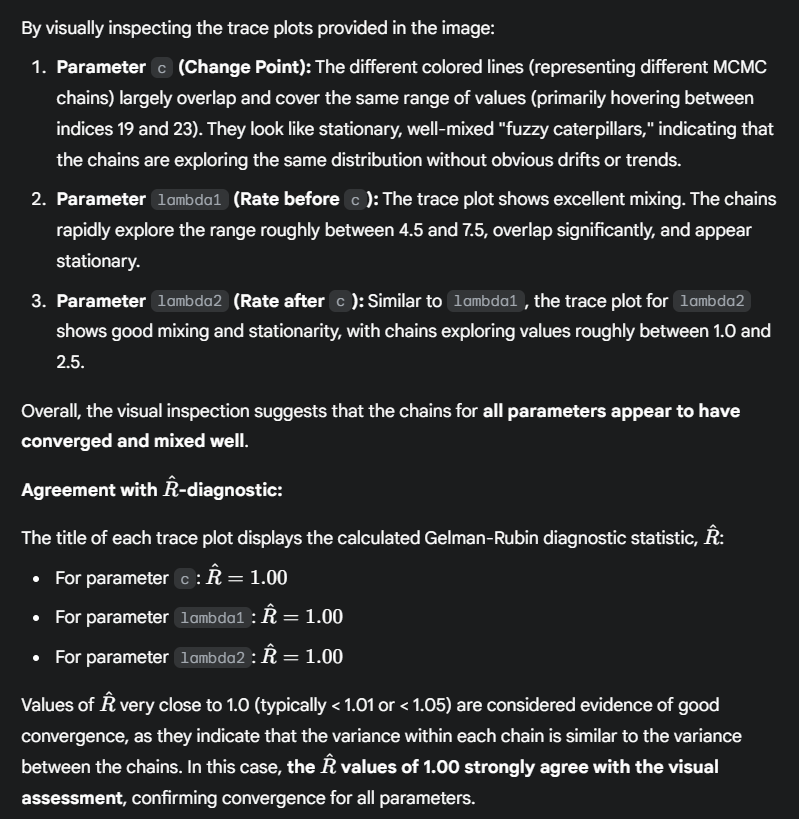

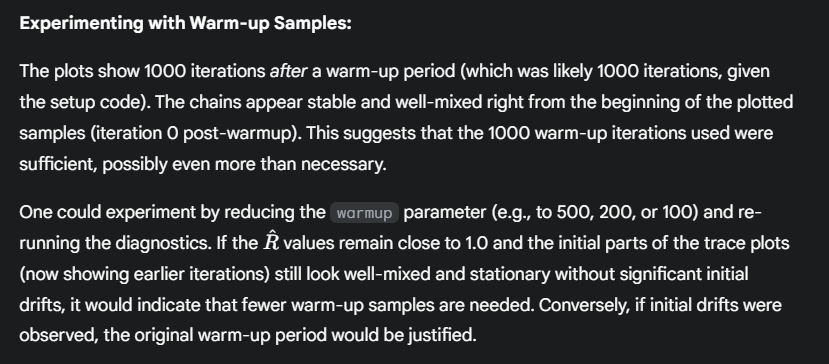

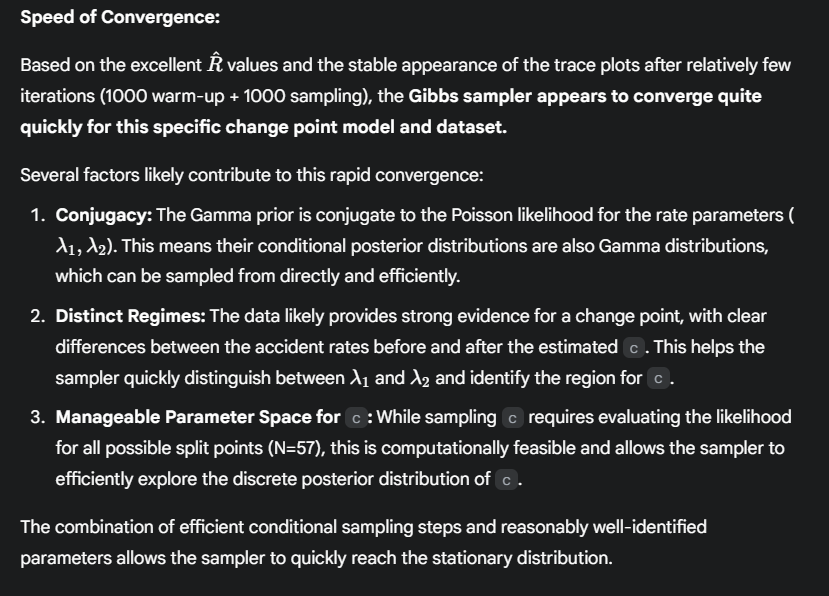

## Part 4:  Visualizing the posterior distributions for the change point detection model

Next, we will visualize the posterior distribution for $\lambda_1, \lambda_2,$ and $c$. First, we will define the Poisson rate $\lambda(\text{t})$ as a function of time $t$ as follows

$$\begin{align*}
\lambda(\text{t}) = \begin{cases} \lambda_1 \quad \text{if} \quad t \leq t_c\\
                           \lambda_2 \quad \text{if} \quad t > t_c,
                        \end{cases}
\end{align*}$$

where $t_c$ denotes the year for the $c$'th observation.

**Task 4.1**: Plot the posterior mean and a 95\% credibility interval of $\lambda(t)$, i.e. $p(\lambda(t)|\mathcal{D})$, superimposed on the data below.

*Hints*: *Merge the chains and then for each posterior sample of $\lambda_1, \lambda_2, c$, compute $\lambda(t)$ for the interval fra year 1851 to 1964. Next, you can compute the mean and interval for each time point and then plot it. You can use the function `plot_summary` for plotting the mean and intervals, or you can implement it on your own.*

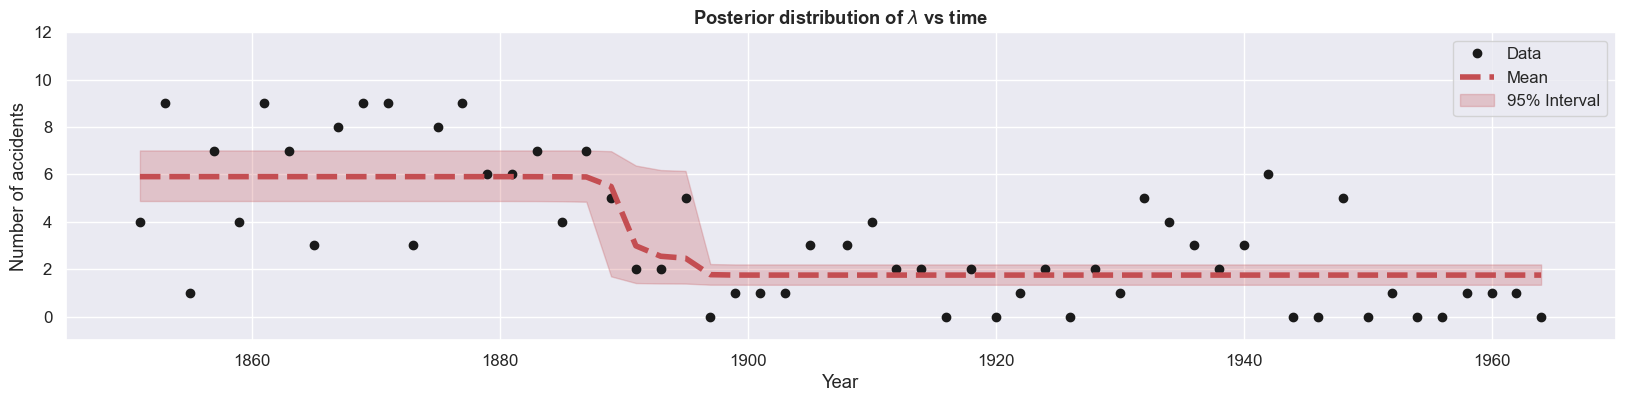

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(20, 4))
plot_data(ax)

##############################################
# Posterior mean and 95% credibility interval for λ(t)
##############################################

# --- Inputs ---
# posterior_samples_merged: shape (num_total_samples, 3), columns: [c, lambda1, lambda2]
# year: shape (N,)
# N: number of time points

# --- Output ---
# lambda_t_samples: shape (num_total_samples, N), each row is λ(t) for one posterior sample

# For each posterior sample (c, lambda1, lambda2), construct λ(t) as:
#   λ(t) = lambda1 for t <= t_c (i.e., indices < c)
#   λ(t) = lambda2 for t > t_c (i.e., indices >= c)

# Merge chains and count total number of samples
# posterior_samples_merged: (num_total_samples, 3)
# num_total_samples: int

lambda_t_samples = []  # Will be (num_total_samples, N)

for (c, lambda1, lambda2) in posterior_samples_merged:
    # c: change point index (float, but should be int)
    # lambda1, lambda2: Poisson rates before/after change point (float)
    c = int(c)
    # λ(t): shape (N,)
    # λ(t) = lambda1 for t < c, lambda2 for t >= c
    lambda_t = jnp.zeros((N,))
    lambda_t = lambda_t.at[:c].set(lambda1)
    lambda_t = lambda_t.at[c:].set(lambda2)
    lambda_t_samples.append(lambda_t)

# Stack into array: shape (num_total_samples, N)
lambda_t_samples = jnp.stack(lambda_t_samples)

# --- Visualization ---
# plot_summary plots mean and 95% interval across posterior samples for each t
# Inputs:
#   ax: matplotlib axis
#   year: shape (N,)
#   lambda_t_samples: shape (num_total_samples, N)
#   num_samples=0: plot all samples
#   title: plot title

plot_summary(ax, year, lambda_t_samples, num_samples=0, title='Posterior distribution of $\\lambda$ vs time')

##############################################
# End of solution
##############################################


Similarly, we can define the number of accidents $x(t)$ as a function of time $t$ as follows

$$\begin{align*}
x(t)|\lambda_1, \lambda_2, c \sim \text{Poisson}(\lambda(t)),
\end{align*}$$


where $\lambda(t)$ is as defined above.

**Task 4.2**: Plot the posterior (predictive) mean and a 95\% credibility interval for $p(x(t)|\mathcal{D})$ superimposed on the data below.

*Hint: Use ancestral sampling*



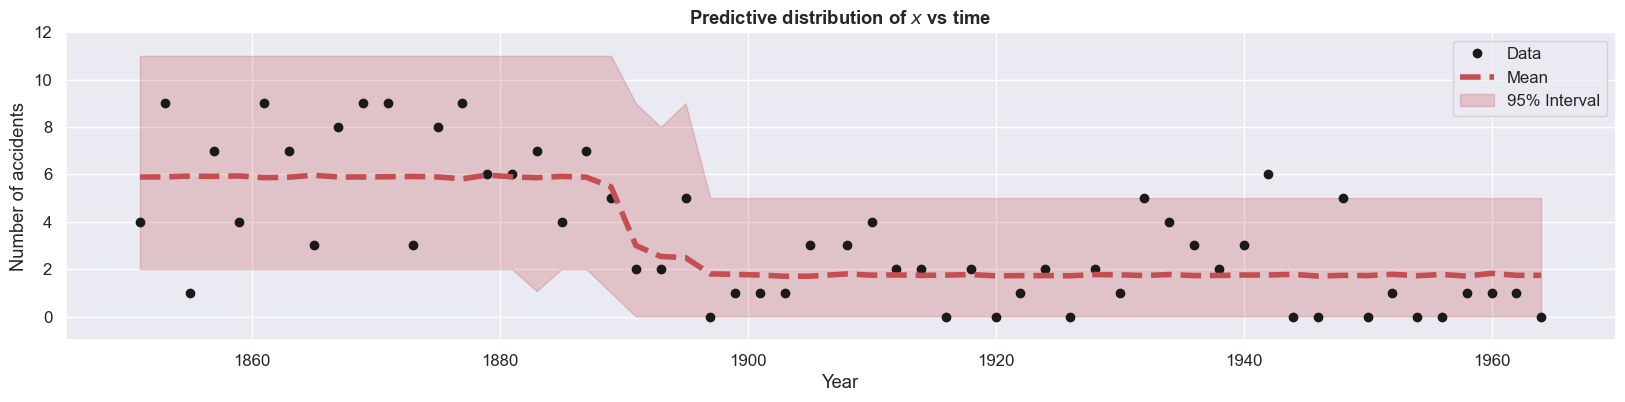

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(20, 4))
plot_data(ax)

##############################################
# Posterior predictive for x(t): p(x(t) | D)
##############################################
# Inputs:
#   lambda_t_samples: shape (num_total_samples, N)
#   key: JAX PRNGKey
#   year: shape (N,)
#   N: int, number of time points
#
# For each posterior sample of lambda_t (i.e., for each row in lambda_t_samples),
#   sample x_t ~ Poisson(lambda_t) independently for each t.
#   Equation: x_t ~ Poisson(lambda_t)
#
# Output:
#   x_t_samples: shape (num_total_samples, N)
#     Each row is a predictive sample of the accident counts for all years.

# Sample predictive accident counts for each posterior sample
# random.poisson(key, lam) draws samples from Poisson(lam)
# Here, lambda_t_samples: (num_total_samples, N)
x_t_samples = random.poisson(key, lambda_t_samples)

# Visualize: plot posterior predictive mean and 95% interval for x(t)
# plot_summary will plot the mean and 95% interval across posterior predictive samples for each year
plot_summary(ax, year, x_t_samples, num_samples=0, title='Predictive distribution of $x$ vs time')

##############################################
# End of solution
##############################################

**Task 4.3**: Compute the posterior mean and standard deviation of the for all posterior parameters, i.e. $\lambda_1$, $\lambda_2$, and $c$ (using all samples for all chains).

In [22]:
# For each parameter (c, lambda1, lambda2), compute and print posterior mean and std
# ---------------------------------------------------------------
# Inputs:
#   posterior_samples_merged: jnp.array, shape (num_total_samples, 3)
#       Each row: [c, lambda1, lambda2] from all chains merged
#   parameter_names: list of str, length 3
#       Names of the parameters: ['c', 'lambda1', 'lambda2']
#
# For each parameter:
#   mean = (1/N) * sum_{i=1}^N x_i
#   std  = sqrt( (1/N) * sum_{i=1}^N (x_i - mean)^2 )
#
# Outputs:
#   Prints mean and std for each parameter
# ---------------------------------------------------------------

for idx_param in range(3):

    # Extract samples for the current parameter
    # posterior_samples_merged[:, idx_param]: shape (num_total_samples,)
    param_samples = posterior_samples_merged[:, idx_param]

    # Compute posterior mean:
    #   mean = (1/N) * sum_{i=1}^N x_i
    mean = jnp.mean(param_samples)

    # Compute posterior standard deviation:
    #   std = sqrt( (1/N) * sum_{i=1}^N (x_i - mean)^2 )
    std = jnp.std(param_samples)

    # Print results
    print(f'{parameter_names[idx_param]}\t\tmean={mean:3.2f}\tstd={std:3.2f}')

c		mean=20.59	std=1.27
lambda1		mean=5.91	std=0.54
lambda2		mean=1.75	std=0.22




**Task 4.4**: Compute the MCSE for the posterior mean for each parameter. Given these estimates, how many significant digits would it make sense to report for the estimate of the posterior mean?



In [23]:
# ---------------------------------------------------------------
# Compute MCSE (Monte Carlo Standard Error) for each parameter
# ---------------------------------------------------------------
# This cell computes the MCSE for the posterior mean of each parameter (c, lambda1, lambda2)
# using all samples from all chains.
#
# MCSE quantifies the uncertainty in the estimated mean due to finite (and autocorrelated) samples.
#
# Equations:
#   For parameter θ:
#     MCSE(θ) = std(θ) / sqrt(S_eff(θ))
#   where:
#     std(θ): posterior standard deviation of θ (across all samples)
#     S_eff(θ): effective sample size for θ (accounts for autocorrelation)
#
# Inputs:
#   posterior_samples_merged: jnp.array, shape (num_total_samples, 3)
#       Each row: [c, lambda1, lambda2] from all chains merged
#   posterior_samples: jnp.array, shape (num_chains, num_samples_per_chain, 3)
#       All samples, shape matches compute_effective_sample_size input
#   parameter_names: list of str, length 3
#       Names of the parameters: ['c', 'lambda1', 'lambda2']
#
# Outputs:
#   Prints for each parameter:
#     - Posterior mean
#     - MCSE for the mean
# ---------------------------------------------------------------

# Compute posterior standard deviation for each parameter (across all samples)
# Shape: (3,)
post_std = jnp.std(posterior_samples_merged, axis=0)

# Compute effective sample size for each parameter
# Input shape: (num_chains, num_samples_per_chain, 3)
# Output shape: (3,)
S_eff = compute_effective_sample_size(posterior_samples)

# Compute MCSE for each parameter
# MCSE = std / sqrt(S_eff), shape: (3,)
MCSE = post_std / jnp.sqrt(S_eff)

# Print results for each parameter
for idx_param in range(3):
    # Posterior mean for parameter idx_param
    mean = jnp.mean(posterior_samples_merged[:, idx_param])
    # MCSE for parameter idx_param
    mcse = MCSE[idx_param]
    # Print with detailed formatting
    print(
        f'{parameter_names[idx_param]}\t\t'
        f'mean = {mean:3.2f}, \t'
        f'MCSE = {mcse:4.3f}'
    )


c		mean = 20.59, 	MCSE = 0.024
lambda1		mean = 5.91, 	MCSE = 0.009
lambda2		mean = 1.75, 	MCSE = 0.004


**Task 4.5**: Recall, $t_n$ is the year of $n$'th observation and $t_c$ is the year of the change point. Plot a histogram of the posterior for $t_c$ and compute posterior mean of $t_c$, i.e. the posterior mean of the year for the change point.



Posterior mean of year for change point: 1892.19


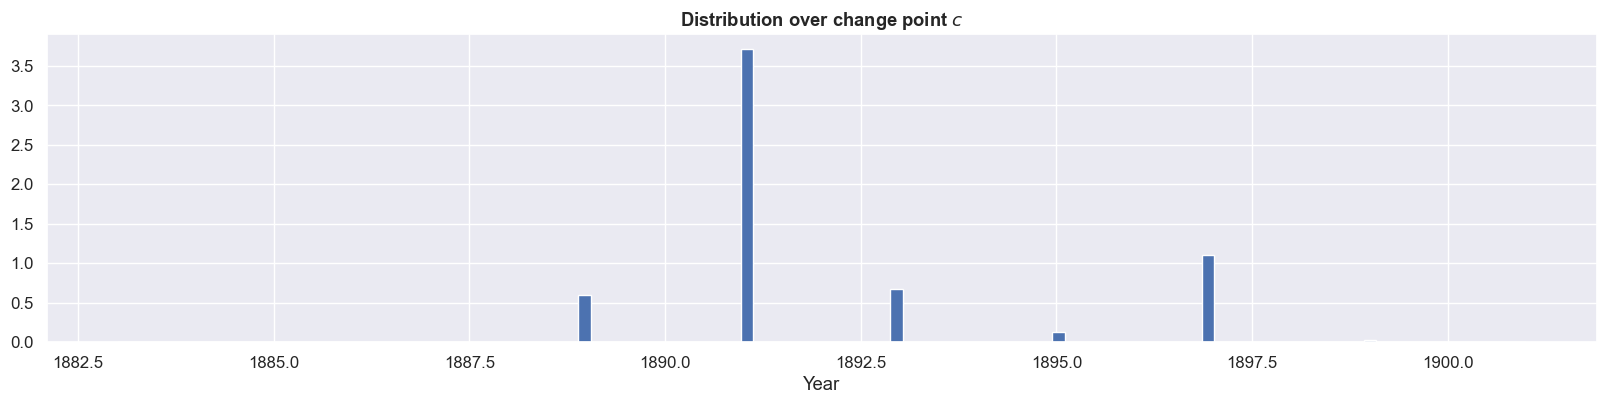

In [24]:
# ---------------------------------------------------------------
# Plot histogram of the posterior for the change point year t_c
# and compute the posterior mean of t_c (the year of the change point)
# ---------------------------------------------------------------
# Inputs:
#   posterior_samples_merged: jnp.array, shape (num_total_samples, 3)
#       Each row: [c, lambda1, lambda2] from all chains merged
#   year: jnp.array, shape (N,)
#       Array of years corresponding to each observation (N = 57)
#
# Steps:
#   1. Extract posterior samples for c (change point index)
#      Shape: (num_total_samples,)
#   2. Convert c (index) to year: t_c = year[c]
#      Shape: (num_total_samples,)
#   3. Plot histogram of t_c (distribution over change point year)
#   4. Compute and print posterior mean of t_c
#
# Equations:
#   t_c^{(i)} = year[c^{(i)}]
#   Posterior mean of t_c:  E[t_c] = (1/M) * sum_{i=1}^M t_c^{(i)}
#
# Outputs:
#   - Histogram plot of t_c (distribution over change point year)
#   - Posterior mean of t_c (printed)
# ---------------------------------------------------------------

# 1. Extract posterior samples for c (change point index)
#    posterior_samples_merged[:, 0]: shape (num_total_samples,)
c_samples = posterior_samples_merged[:, 0].astype('int')

# 2. Convert c (index) to year: t_c = year[c]
#    year: shape (N,), c_samples: shape (num_total_samples,)
changepoint_samples = year[c_samples]  # shape: (num_total_samples,)

# 3. Plot histogram of t_c (distribution over change point year)
fig, ax = plt.subplots(1, 1, figsize=(20, 4))
# Number of bins: one per year interval
num_bins = int(year[-1] - year[0])
ax.hist(changepoint_samples, num_bins, density=True)
ax.set_xlabel('Year')
ax.set_title('Distribution over change point $c$', fontweight='bold')

# 4. Compute and print posterior mean of t_c
#    E[t_c] = (1/M) * sum_{i=1}^M t_c^{(i)}
mean_tc = jnp.mean(changepoint_samples)
print(f'Posterior mean of year for change point: {mean_tc:3.2f}')


**Task 4.6**: Compute the posterior mean of $x(t)$ for $t \in \left\lbrace 1880,1895, 1920 \right\rbrace$



In [25]:
# ---------------------------------------------------------------
# Compute the posterior mean of x(t) for t in {1880, 1895, 1920}
# ---------------------------------------------------------------
# For each time t in t_vals, we want to compute the posterior predictive mean and std of x(t),
# where x(t) | λ1, λ2, c ~ Poisson(λ(t)), and λ(t) is determined by the posterior samples:
#   λ(t) = lambda1 if t <= year[c], else lambda2
#
# For each posterior sample (c, lambda1, lambda2), we:
#   1. Determine λ(t) for the given t and sample.
#   2. Draw a sample x ~ Poisson(λ(t)) using JAX's random.poisson.
#   3. Repeat for all posterior samples to get the posterior predictive distribution for x(t).
#   4. Compute the mean and std of x(t) across all posterior samples.
#
# Input shapes:
#   t_vals: list of int or float, times of interest, e.g. [1880, 1895, 1920]
#   year: jnp.array, shape (N,), years of observations
#   posterior_samples_merged: jnp.array, shape (num_total_samples, 3), columns: [c, lambda1, lambda2]
#
# Output:
#   For each t in t_vals, prints the posterior predictive mean and std of x(t)
# ---------------------------------------------------------------

t_vals = [1880, 1895, 1920]

# key: JAX PRNGKey for reproducibility
key = random.PRNGKey(1)

for i, t in enumerate(t_vals):
    # Split key for randomness in each t
    key, subkey = random.split(key)

    # For each posterior sample, select lambda1 if t <= year[c], else lambda2
    # posterior_samples_merged: shape (num_total_samples, 3)
    #   c: index of change point (float, but should be int)
    #   lambda1, lambda2: Poisson rates
    #
    # For each sample, compute:
    #   λ(t) = lambda1 if t <= year[int(c)] else lambda2
    lambda_samples = jnp.array([
        lambda1 if t <= year[int(c)] else lambda2
        for c, lambda1, lambda2 in posterior_samples_merged
    ])  # shape: (num_total_samples,)

    # Draw predictive samples: x ~ Poisson(λ(t)) for each posterior sample
    # random.poisson(subkey, lam): draws samples from Poisson(lam)
    x_samples = random.poisson(subkey, lambda_samples)  # shape: (num_total_samples,)

    # Compute posterior predictive mean and std for x(t)
    mean_x = jnp.mean(x_samples)
    std_x = jnp.std(x_samples)

    # Print results
    print(
        f'Posterior predictive for x({t}): '
        f'mean = {mean_x:3.2f}, std = {std_x:3.2f}'
    )


Posterior predictive for x(1880): mean = 5.91, std = 2.50
Posterior predictive for x(1895): mean = 2.58, std = 2.21
Posterior predictive for x(1920): mean = 1.75, std = 1.37


please add me a detailed comments, equations and input and output shapes:

**Task 4.7**: Compute the posterior probability $P(c < 20|\mathcal{D})$, i.e  that the change point $c$ is strictly smaller than $20$.



In [27]:
# ---------------------------------------------------------------
# Compute the posterior probability P(c < 20 | x)
# ---------------------------------------------------------------
# This cell calculates the probability that the change point c is strictly less than 20,
# given the observed data and the posterior samples from the Gibbs sampler.
#
# Equations:
#   - Let c^{(i)} be the i-th posterior sample of the change point index c.
#   - The posterior probability is estimated as:
#         P(c < 20 | x) ≈ (1/M) * sum_{i=1}^M I[c^{(i)} < 20]
#     where:
#         - I[condition] is the indicator function (1 if condition is true, 0 otherwise)
#         - M is the total number of posterior samples (across all chains)
#
# Input shapes:
#   - posterior_samples_merged: jnp.array, shape (num_total_samples, 3)
#       Each row: [c, lambda1, lambda2] from all chains merged
#
# Output:
#   - prob: scalar, estimated posterior probability P(c < 20 | x)
#   - Printed output of the probability
# ---------------------------------------------------------------

# Extract all posterior samples for c (change point index)
# posterior_samples_merged[:, 0]: shape (num_total_samples,)
c_samples_all = posterior_samples_merged[:, 0]

# Compute the posterior probability that c < 20
# This is the mean of the indicator function over all samples
prob = jnp.mean(c_samples_all < 20)

# Print the result
print('P(c < 20|x):\t\t%3.2f' % prob)

P(c < 20|x):		0.10


**Task 4.8**: Compute the posterior probability for $\lambda_1$ being more than 3 times larger than $\lambda_2$.

In [28]:
# ---------------------------------------------------------------
# Compute the posterior probability that lambda1 > 3 * lambda2
# ---------------------------------------------------------------
# This cell estimates the probability that the Poisson rate parameter before the change point (lambda1)
# is more than three times larger than the rate after the change point (lambda2), using all posterior samples.
#
# Equations:
#   - Let (lambda1^{(i)}, lambda2^{(i)}) be the i-th posterior sample for (lambda1, lambda2).
#   - The posterior probability is estimated as:
#         P(lambda1 > 3 * lambda2 | x) ≈ (1/M) * sum_{i=1}^M I[lambda1^{(i)} > 3 * lambda2^{(i)}]
#     where:
#         - I[condition] is the indicator function (1 if condition is true, 0 otherwise)
#         - M is the total number of posterior samples (across all chains)
#
# Input shapes:
#   - posterior_samples_merged: jnp.array, shape (num_total_samples, 3)
#       Each row: [c, lambda1, lambda2] from all chains merged
#
# Output:
#   - Prints the estimated posterior probability (scalar, float)
# ---------------------------------------------------------------

# Extract all posterior samples for lambda1 and lambda2
# posterior_samples_merged[:, 1]: shape (num_total_samples,) -- lambda1 samples
# posterior_samples_merged[:, 2]: shape (num_total_samples,) -- lambda2 samples
lambda1_samples = posterior_samples_merged[:, 1]
lambda2_samples = posterior_samples_merged[:, 2]

# Compute the indicator for each sample: 1 if lambda1 > 3 * lambda2, else 0
I = lambda1_samples > 3 * lambda2_samples  # shape: (num_total_samples,)

# Estimate the posterior probability as the mean of the indicator
prob = jnp.mean(I)  # shape: scalar

# Print the result
print(f'Posterior probability of lambda1 > 3*lambda2: {prob:4.3f}')

Posterior probability of lambda1 > 3*lambda2: 0.784
